# Time Series in Python
# Practical approach
# Homework task

Автор: Сергеев Дмитрий

https://github.com/DmitrySerg

In [1]:
import numpy as np                               # работа с векторами и матрицами
import pandas as pd                              # таблицы и операции над данными
import matplotlib.pyplot as plt                  # графики
import seaborn as sns                            # еще графики

from dateutil.relativedelta import relativedelta # для комфортной работы с датами
from scipy.optimize import minimize              # позволяет минимизировать функции

import statsmodels.formula.api as smf            # всякая статистика и эконометрика
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # немножко функций для удобства
from tqdm import tqdm_notebook

import warnings                                  # чтобы никто не мешал бесчинствам с кодом
warnings.filterwarnings('ignore')

%matplotlib inline



from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

В этой домашней работе вам предстоит поработать с двумя временными рядами, один - уже знакомый ряд с тратой внутриигровой валюты `currency`, второй - установки по дням в одном из наших приложений, `installs`

In [2]:
currency = pd.read_csv('data/currency.csv', index_col=['Time'], parse_dates=['Time'])
installs = pd.read_csv('data/installs.csv', index_col=['Time'], parse_dates=['Time'])

Снова посмотрим на графики временных рядов

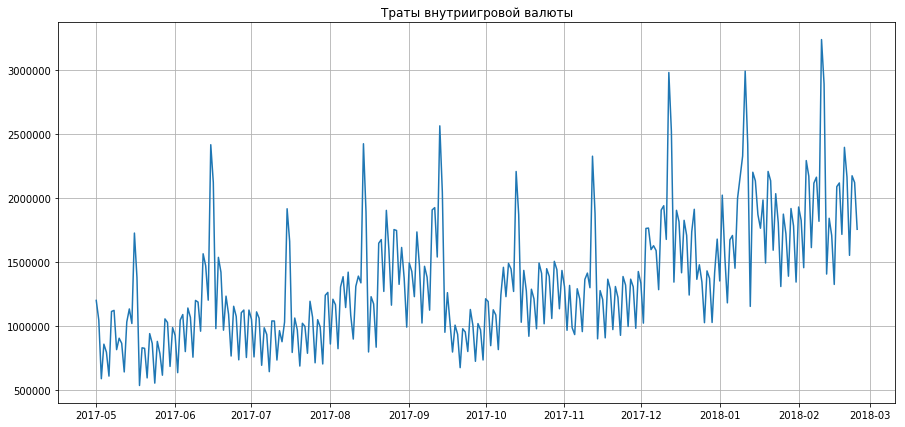

In [3]:
plt.figure(figsize=(15, 7))
plt.plot(currency.GEMS_GEMS_SPENT)
plt.title('Траты внутриигровой валюты')
plt.grid(True)
plt.show()

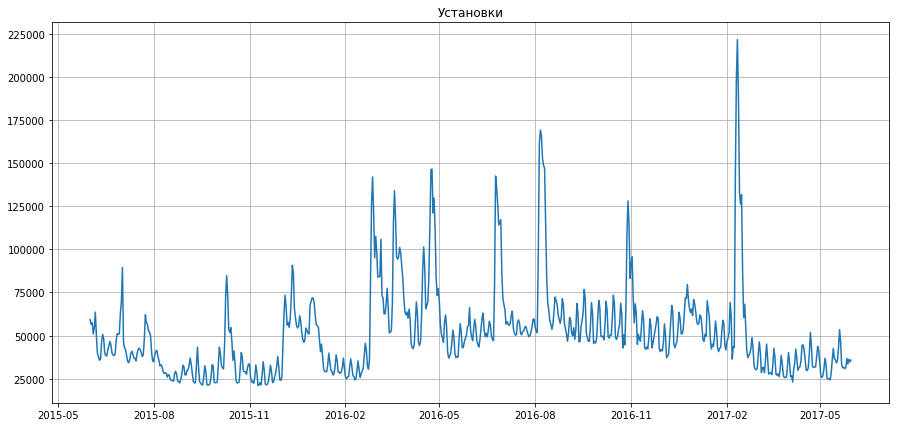

In [4]:
plt.figure(figsize=(15, 7))
plt.plot(installs)
plt.title('Установки')
plt.grid(True)
plt.show()

У первого временного ряда явно есть и сезонность, и тренд, а вот второй ряд с установками имеет очень много выбросов, которые никак не характеризуются сезонными изменениями.

Для начала поработаем с моделью тройного экспоненциального сглаживания - моделью Хольта-Винтерса

In [5]:
from sklearn.model_selection import TimeSeriesSplit 
from HoltWinters import HoltWinters                 

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # вектор ошибок
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

Задание:

- Построить модель для временного ряда с установками, используя `mean_squared_error` в качестве функции потерь
- Сначала постройте модель на всём ряду installs.Users, отложив только последние 50 наблюдений для тестирования, убедитесь, что прогноз по такой модели будет сильно заниженным
- Теперь возьмите для моделирования только последние 500 наблюдений, для этого возьмите от временного ряда срез [500:-50], чтобы учесть в модели только последние изменения и не пытаться подогнать параметры под историю, которая уже стала нерелевантной

In [6]:
%%time
data = installs.Users[:-50] # отложим 50 наблюдений для тестирования
slen = 7 # недельная сезонность
# инициализируем значения параметров
x = [0, 0, 0] 

# Минимизируем квадратичную функцию потерь с ограничениями на параметры 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, 
                     mean_absolute_percentage_error, 
                     slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)


model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.0 0.0 0.0
Wall time: 406 ms


А теперь обрежем наши данные, чтобы обучаться на последнем промежутке времени, наиболее релевантным для сегодняшних значений

In [7]:
%%time
data = installs.Users[500:-50] 
slen = 7
x = [0, 0, 0] 

# Минимизируем квадратичную функцию потерь с ограничениями на параметры 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, 
                     mean_absolute_percentage_error, 
                     slen), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Из оптимизатора берем оптимальное значение параметров
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)


model = HoltWinters(data, slen = slen, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.0 0.0 7.24037808249034e-05
Wall time: 939 ms


Прекрасно! Мы снова можем ловить аномалии, а модель неплохо описывает поведение нашего временного ряда и строит правдоподобный прогноз

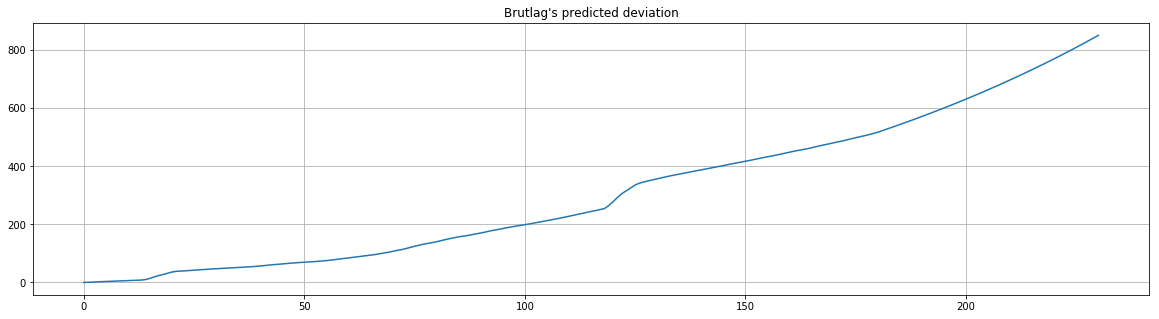

In [8]:
plt.figure(figsize=(20, 5))
plt.plot(model.PredictedDeviation)
plt.grid(True)
plt.axis('tight')
plt.title("Brutlag's predicted deviation");

По графику смоделированной дисперсии легко увидеть, как выброс в наших данных значительно увеличил отклонение и вызвал расширение доверительных интерваловна некоторых промежуток времени

# Эконометрический подход

In [9]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])
        plt.tight_layout()

In [10]:
def optimizeSARIMA(parameters_list, d, D, s):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # try except нужен, потому что на некоторых наборах параметров модель не обучается
        try:
            model=sm.tsa.statespace.SARIMAX(currency.GEMS_GEMS_SPENT, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[3], D, param[3], s)).fit(disp=-1)
        except ValueError:
            continue
        aic = model.aic
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # сортируем по возрастанию, чем меньше критерий AIC, тем лучше
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [11]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # подставляем модельные значения
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # делаем отступ на s+d, так как эти значения в модели были ненаблюдаемыми
    # из-за дифференцирования
    data['arima_model'][:s+d] = np.NaN
    
    # прогнозируем на n_steps шагов вперёд 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # считаем ошибку, также отступив s+d шагов от начала
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

В качестве домашнего задания и хорошей практики для закрепления - по аналогии с лекцией построить модель SARIMA для прогнозирования временного ряда с тратой внутриигровой валюты, в котором присутствует тренд (убирается при помощи первых разностей) и месячная сезонность (сезонное дифференцирование с периодом 30)

Критерий Дики-Фуллера: p=0.372542


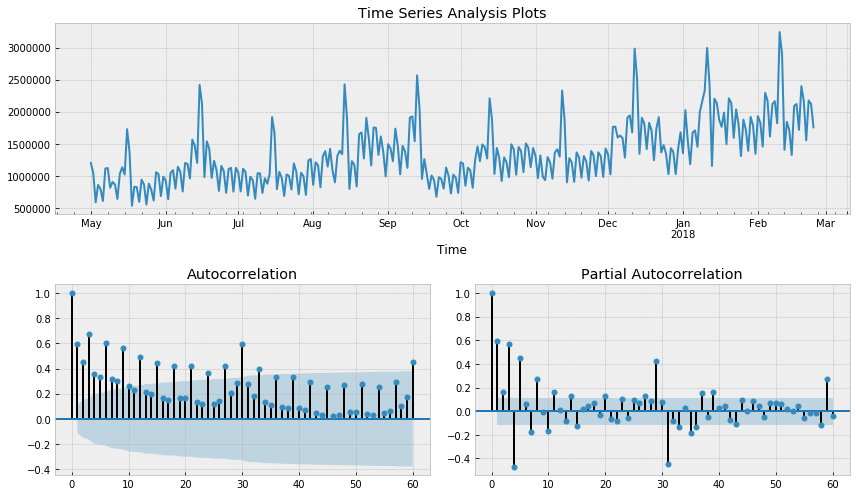

In [12]:
tsplot(currency.GEMS_GEMS_SPENT, lags=60)

# TODO
# - привести ряд к стационарному виду
# - по ACF, PACF определить начальные значения параметров модели и возможные интервалы
# - перебором параметров подобрать оптимальную модель и построить её
# - построить график модельных значений и остатков, убедиться в адекватности результатов

Критерий Дики-Фуллера: p=0.000061


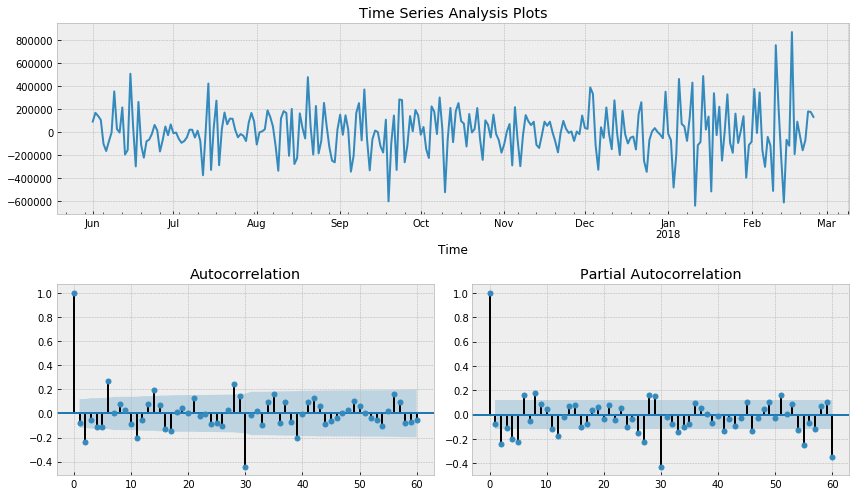

In [13]:
# привести ряд к стационарному виду

gems_diff = currency.GEMS_GEMS_SPENT - currency.GEMS_GEMS_SPENT.shift(30)
gems_diff = gems_diff - gems_diff.shift(1)
tsplot(gems_diff[30+1:], lags=60)

In [14]:
# зададим ограничения на возможные значения параметров для перебора
ps = range(2, 5)
d= 1
qs = range(2, 5)

Ps = range(0, 2)
D= 1
Qs = range(0, 2)
s = 30

# создадим лист с возможными параметрами и посчитаем его длину
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [15]:
%%time
result_table = optimizeSARIMA(parameters_list, d, D, s)


Wall time: 5min 36s


In [16]:
# передаём параметры с минимальным AIC
p, q, P, Q = result_table.parameters[0]

# обучаем лучшую модель
best_model=sm.tsa.statespace.SARIMAX(currency.GEMS_GEMS_SPENT, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)

print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                    GEMS_GEMS_SPENT   No. Observations:                  300
Model:             SARIMAX(4, 1, 4)x(1, 1, 1, 30)   Log Likelihood               -3605.847
Date:                            Tue, 29 May 2018   AIC                           7233.694
Time:                                    18:23:23   BIC                           7273.236
Sample:                                05-01-2017   HQIC                          7249.574
                                     - 02-24-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2182      0.044      4.930      0.000       0.131       0.305
ar.L2         -0.7240      0.048   

# Machine Learning для временных рядов

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
# from xgboost import XGBRegressor
from catboost import CatBoostRegressor # на моем PC OS Win10, поэтому есть некоторые проблемы с xgboost

scaler = StandardScaler()
# для рассчета ошибки на кросс-валидации будем бить ряд на 5 фолдов
tscv = TimeSeriesSplit(n_splits=5)

In [18]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(X)*(1-test_size))
    
    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [19]:
def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False):
    """
    Строит график прогнозных и фактических значений, а также доверительных интервалов прогноза и аномалий
    
    """
    
    # получаем предсказания по модели
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (scale * deviation)
        upper = prediction + (scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
    Отрисовывает отсортированные по абсолютному значению коэффициенты модели
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

In [20]:
def code_mean(data, cat_feature, real_feature):
    """
    Возвращает словарь, где ключами являются уникальные категории признака cat_feature, 
    а значениями - средние по real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [21]:
# оригинал функции

def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # Создадим копию исходного датафрейма, чтобы можно было выполнять различные преобразования
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # Добавляем лаги целевой переменной
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # Добавляем данные по часу, дню недели и выходным
    data.index = data.index.to_datetime()
    data["hour"] = data.index.hour
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # считаем средние только по тренировочной части, чтобы избежать лика
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

        # выкидываем закодированные средними признаки 
        data.drop(["hour", "weekday"], axis=1, inplace=True)
    
    # Делим на тренировочную и тестовую
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

Снова небольшим домашним заданием будет построение моделей для временного ряда с внутриигровой валютой.

TODO

- Изменить функцию `prepareData` так, чтобы она не извлекала признак "час" и "среднее по часу", а вместо этого добавить извлечение признака "день месяца" и "среднее по дню месяца"
- Подготовить данные для построения модели, взяв `lag_start = 7`, чтобы модель могла прогнозировать на неделю вперед, а `lag_end = 31`, чтобы месячная сезонность также попала в наблюдаемые моделью значения
- Построить линейную модель с `target_encoding` (среднее по дню месяца) и без, проверить, что лучше
- Построить ридж и лассо регрессии, посмотреть, какие факторы модели считают наиболее важными
- Забустить этот временной ряд и убедиться, что по умолчанию `xgb` будет давать отвратительный результат

Крутое бонус-задание
- Разбейте подготовленные данные на `train` и `test`
- Очистите временной ряд от линейного тренда при помощи построения однофакторной линейной регрессии, где таргетом будут значения ряда, а фактором - числовой ряд от 0 до `len(train)`. Предсказанные по такой модели значения будут линейным трендом, который нужно вычесть из исходного ряда (подбробнее можно посмотреть [здесь](https://machinelearningmastery.com/time-series-trends-in-python/))
- Теперь спрогнозируйте значения тренда по этой модели для тестового датасета, для этого нужно в качестве фактора взять числовой ряд от `len(train)` до `len(test)`, очистите тестовый датасет от тренда при помощи этого прогноза
- Далее на очищенных от тренда данных `train` постройте xgboost и постройте прогноз на `test`
- Наконец, просуммируйте предсказанное значение тренда и прогнозы бустинга, чтобы получить красивый итоговый прогноз временного ряда

In [22]:
# Изменить функцию prepareData так, чтобы она не извлекала признак "час" и "среднее по часу",
# а вместо этого добавить извлечение признака "день месяца" и "среднее по дню месяца"

def prepareData(series, lag_start, lag_end, test_size, target_encoding=False):
    """
        series: pd.DataFrame
            dataframe with timeseries

        lag_start: int
            initial step back in time to slice target variable 
            example - lag_start = 1 means that the model 
                      will see yesterday's values to predict today

        lag_end: int
            final step back in time to slice target variable
            example - lag_end = 4 means that the model 
                      will see up to 4 days back in time to predict today

        test_size: float
            size of the test dataset after train/test split as percentage of dataset

        target_encoding: boolean
            if True - add target averages to the dataset
        
    """
    
    # Создадим копию исходного датафрейма, чтобы можно было выполнять различные преобразования
    data = pd.DataFrame(series.copy())
    data.columns = ["y"]
    
    # Добавляем лаги целевой переменной
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
    
    # Добавляем данные по часу, дню недели и выходным
    # data.index = data.index.to_datetime()
    # data["hour"] = data.index.hour
    data["day"] = data.index.day
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    if target_encoding:
        # считаем средние только по тренировочной части, чтобы избежать лика
        test_index = int(len(data.dropna())*(1-test_size))
        data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
        # data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))
        data["day_average"] = list(map(code_mean(data[:test_index], 'day', "y").get, data.day))

        # выкидываем закодированные средними признаки 
        # data.drop(["hour", "weekday"], axis=1, inplace=True)
        data.drop(["day", "weekday"], axis=1, inplace=True)
    
    # Делим на тренировочную и тестовую
    y = data.dropna().y
    X = data.dropna().drop(['y'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=test_size)

    return X_train, X_test, y_train, y_test

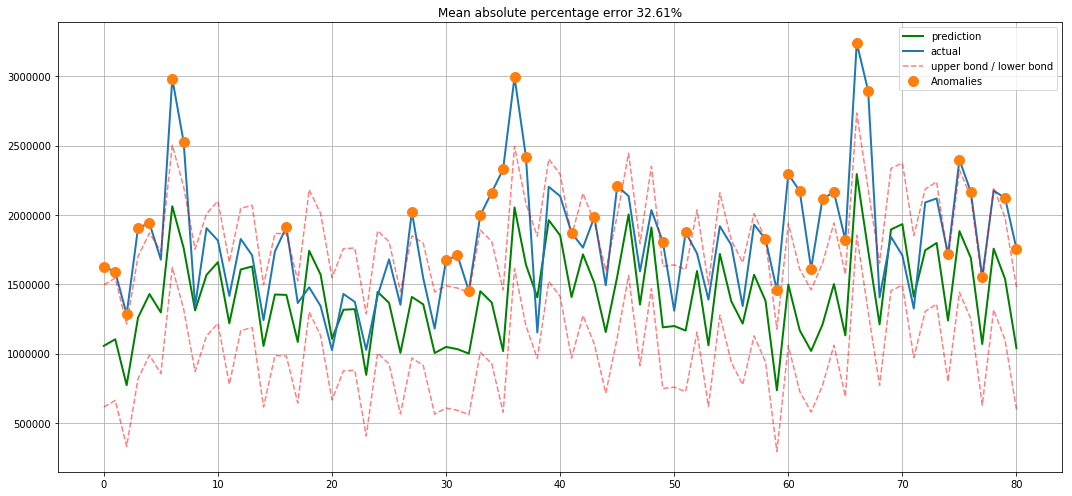

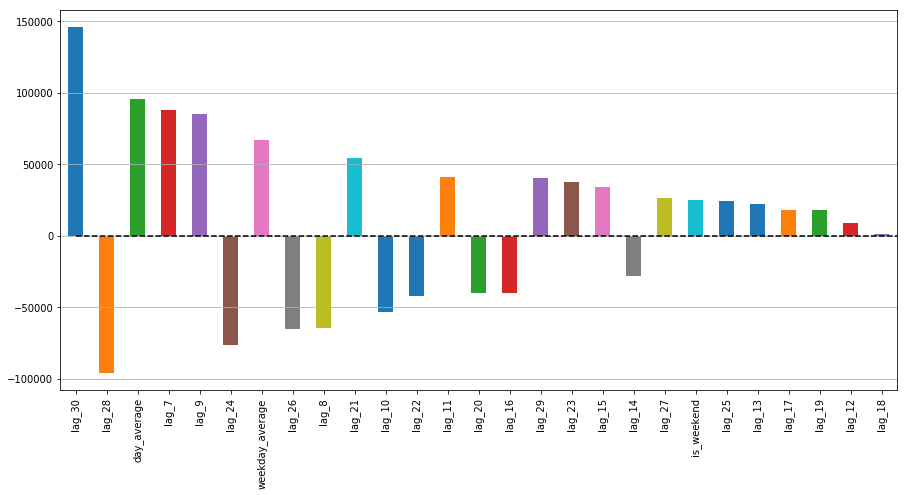

In [23]:
# Подготовить данные для построения модели, взяв lag_start = 7,
# чтобы модель могла прогнозировать на неделю вперед, а lag_end = 31,
# чтобы месячная сезонность также попала в наблюдаемые моделью значения

# Построить линейную модель с target_encoding (среднее по дню месяца) и без, проверить, что лучше
# linreg with target encoding

X_train, X_test, y_train, y_test =\
prepareData(currency.GEMS_GEMS_SPENT, lag_start=7, lag_end=31, test_size=0.3, target_encoding=True)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train_scaled, y_train)

plotModelResults(lr, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

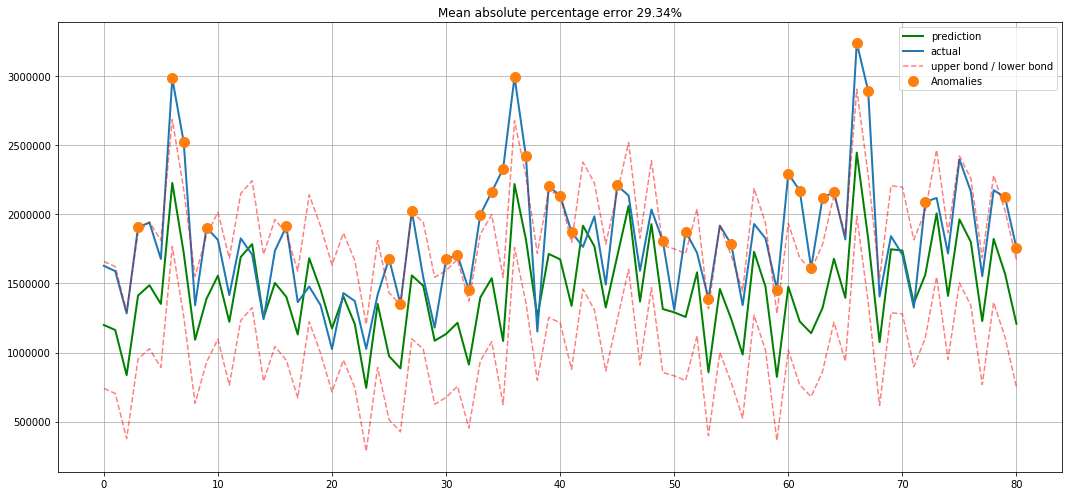

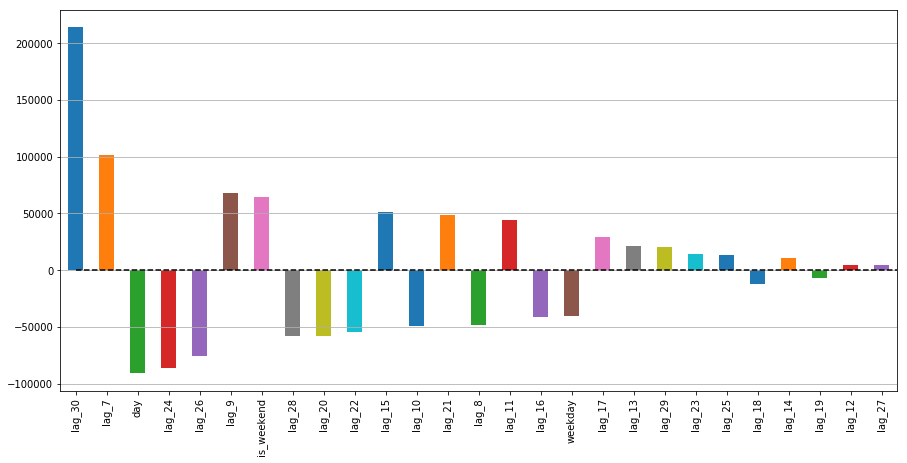

In [24]:
# Подготовить данные для построения модели, взяв lag_start = 7,
# чтобы модель могла прогнозировать на неделю вперед, а lag_end = 31,
# чтобы месячная сезонность также попала в наблюдаемые моделью значения

# Построить линейную модель с target_encoding (среднее по дню месяца) и без, проверить, что лучше
# linreg wo target encoding

X_train, X_test, y_train, y_test =\
prepareData(currency.GEMS_GEMS_SPENT, lag_start=7, lag_end=31, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train_scaled, y_train)

plotModelResults(lr, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lr)

In [25]:
# лучший результат достигается на линейной модели без target encoding ( см. график выше )

In [26]:
# Подготовить данные для построения модели, взяв lag_start = 7,
# чтобы модель могла прогнозировать на неделю вперед, а lag_end = 31,
# чтобы месячная сезонность также попала в наблюдаемые моделью значения

X_train, X_test, y_train, y_test =\
prepareData(currency.GEMS_GEMS_SPENT, lag_start=7, lag_end=31, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

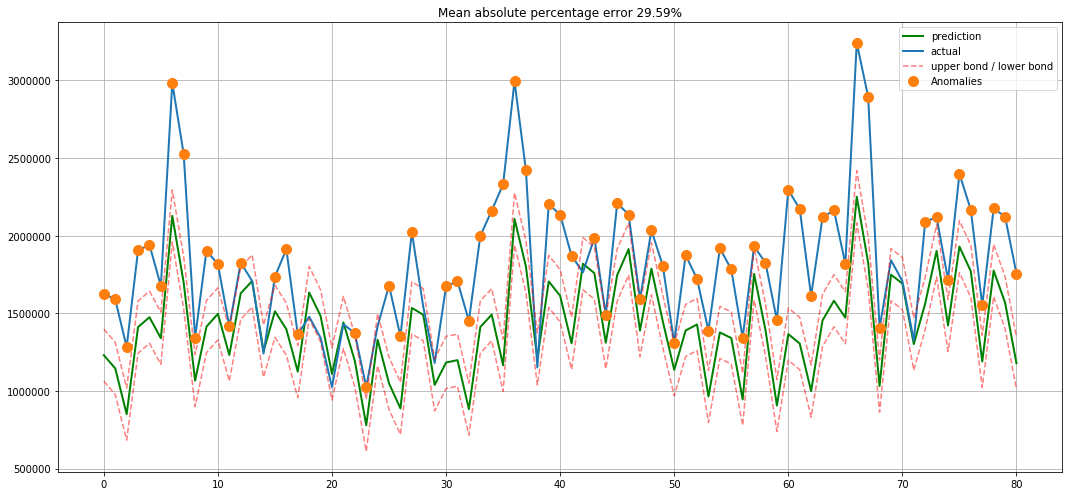

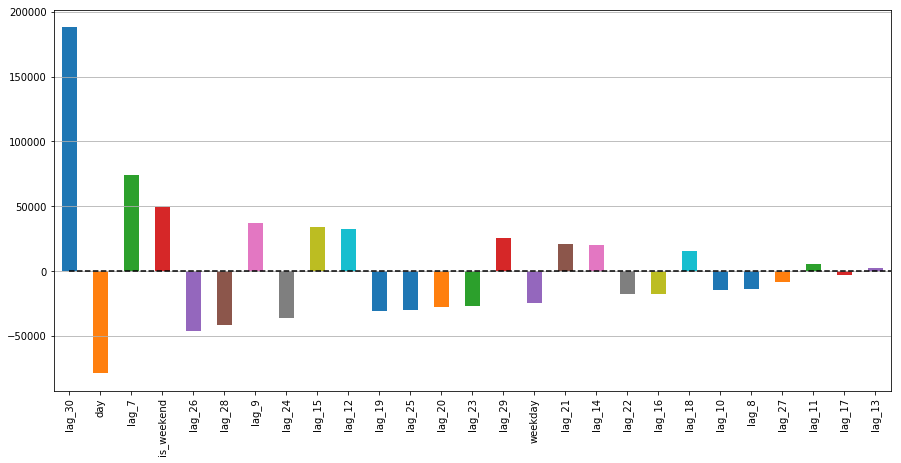

In [27]:
# Построить ридж и лассо регрессии, посмотреть, какие факторы модели считают наиболее важными
# ridge

from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

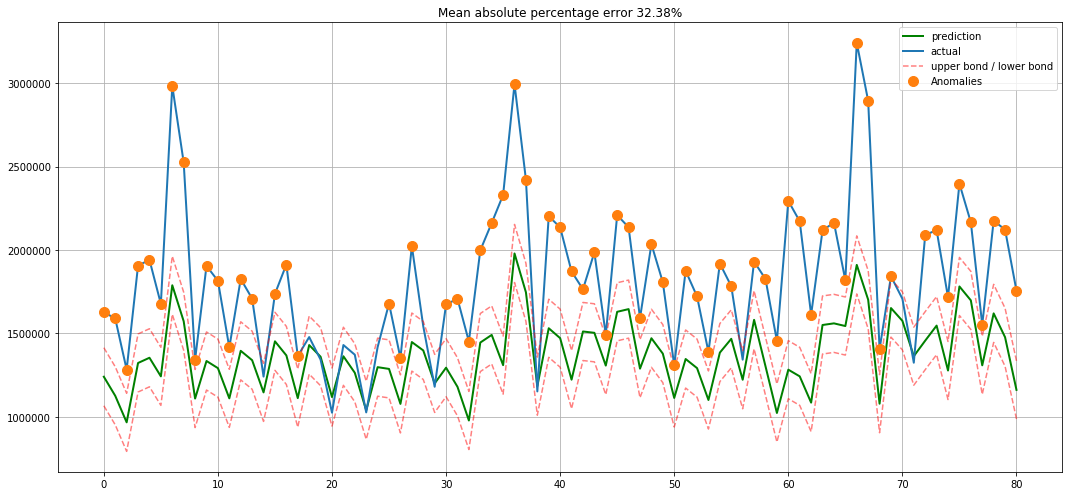

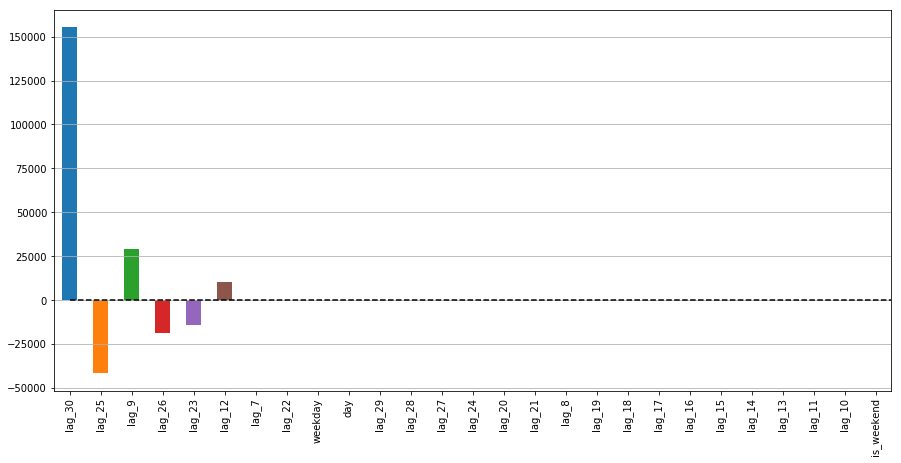

In [28]:
# Построить ридж и лассо регрессии, посмотреть, какие факторы модели считают наиболее важными
# lasso

lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

In [29]:
# наиболее важным фактором в модели являются: lag_30, lag_26
# остальные важные факторы зависят от типа модели, которую мы строим:
# для ridge: lag_30, day, lag_7, is_weekend, lag_26, lag_28
# для lasso: lag_30, lag_25, lag_9, lag_26, lag_23, lag_12

0:	learn: 1244967.7577704	total: 168ms	remaining: 2m 48s
1:	learn: 1214552.6784035	total: 197ms	remaining: 1m 38s
2:	learn: 1185861.4726522	total: 220ms	remaining: 1m 13s
3:	learn: 1155742.0817381	total: 247ms	remaining: 1m 1s
4:	learn: 1127230.7659980	total: 272ms	remaining: 54.2s
5:	learn: 1101502.4950497	total: 298ms	remaining: 49.4s
6:	learn: 1074160.0370121	total: 323ms	remaining: 45.8s
7:	learn: 1051711.6454547	total: 345ms	remaining: 42.8s
8:	learn: 1029271.2538344	total: 372ms	remaining: 40.9s
9:	learn: 1005221.5594393	total: 394ms	remaining: 39.1s
10:	learn: 980693.6492663	total: 407ms	remaining: 36.6s
11:	learn: 959458.6376604	total: 429ms	remaining: 35.3s
12:	learn: 938738.2489410	total: 452ms	remaining: 34.3s
13:	learn: 917362.4908541	total: 477ms	remaining: 33.6s
14:	learn: 894705.0443837	total: 495ms	remaining: 32.5s
15:	learn: 873368.2964536	total: 521ms	remaining: 32s
16:	learn: 855708.4398267	total: 552ms	remaining: 31.9s
17:	learn: 836166.4058308	total: 578ms	remainin

147:	learn: 221325.1500267	total: 4s	remaining: 23s
148:	learn: 220028.5925524	total: 4.03s	remaining: 23s
149:	learn: 219547.6357936	total: 4.06s	remaining: 23s
150:	learn: 218531.0213278	total: 4.08s	remaining: 22.9s
151:	learn: 217761.9014404	total: 4.11s	remaining: 22.9s
152:	learn: 216903.7006440	total: 4.13s	remaining: 22.9s
153:	learn: 216652.6458061	total: 4.15s	remaining: 22.8s
154:	learn: 215733.9025561	total: 4.18s	remaining: 22.8s
155:	learn: 215241.9710091	total: 4.2s	remaining: 22.7s
156:	learn: 215094.3437067	total: 4.21s	remaining: 22.6s
157:	learn: 214639.8430498	total: 4.23s	remaining: 22.6s
158:	learn: 213685.2359157	total: 4.26s	remaining: 22.5s
159:	learn: 213474.1622054	total: 4.29s	remaining: 22.5s
160:	learn: 212687.5882936	total: 4.31s	remaining: 22.5s
161:	learn: 212237.9578869	total: 4.34s	remaining: 22.4s
162:	learn: 211686.2203202	total: 4.37s	remaining: 22.4s
163:	learn: 211198.2429484	total: 4.39s	remaining: 22.4s
164:	learn: 210896.3953060	total: 4.42s	r

292:	learn: 173571.6317776	total: 7.66s	remaining: 18.5s
293:	learn: 173456.3839324	total: 7.69s	remaining: 18.5s
294:	learn: 173263.5706041	total: 7.71s	remaining: 18.4s
295:	learn: 173170.7127223	total: 7.74s	remaining: 18.4s
296:	learn: 173000.1900986	total: 7.76s	remaining: 18.4s
297:	learn: 172899.1956021	total: 7.79s	remaining: 18.3s
298:	learn: 172814.4508954	total: 7.82s	remaining: 18.3s
299:	learn: 172697.2992915	total: 7.84s	remaining: 18.3s
300:	learn: 172463.5178556	total: 7.87s	remaining: 18.3s
301:	learn: 172333.2454999	total: 7.89s	remaining: 18.2s
302:	learn: 172190.9033626	total: 7.91s	remaining: 18.2s
303:	learn: 172091.8552566	total: 7.94s	remaining: 18.2s
304:	learn: 172005.6940704	total: 7.96s	remaining: 18.1s
305:	learn: 171924.1418528	total: 7.99s	remaining: 18.1s
306:	learn: 171793.4127674	total: 8.01s	remaining: 18.1s
307:	learn: 171729.4249268	total: 8.03s	remaining: 18s
308:	learn: 171615.6520974	total: 8.05s	remaining: 18s
309:	learn: 171581.7307354	total: 8

437:	learn: 157554.6937743	total: 11.2s	remaining: 14.4s
438:	learn: 157521.2051257	total: 11.2s	remaining: 14.4s
439:	learn: 156538.1597988	total: 11.3s	remaining: 14.3s
440:	learn: 156538.0684405	total: 11.3s	remaining: 14.3s
441:	learn: 156526.9088779	total: 11.3s	remaining: 14.3s
442:	learn: 156497.8712803	total: 11.3s	remaining: 14.2s
443:	learn: 156444.5802293	total: 11.3s	remaining: 14.2s
444:	learn: 156388.7980155	total: 11.4s	remaining: 14.2s
445:	learn: 156373.6883680	total: 11.4s	remaining: 14.2s
446:	learn: 156179.2856819	total: 11.4s	remaining: 14.1s
447:	learn: 156064.4772564	total: 11.4s	remaining: 14.1s
448:	learn: 156040.3185189	total: 11.5s	remaining: 14.1s
449:	learn: 156013.0691323	total: 11.5s	remaining: 14s
450:	learn: 155991.8688223	total: 11.5s	remaining: 14s
451:	learn: 155955.1071324	total: 11.5s	remaining: 14s
452:	learn: 155859.1517275	total: 11.6s	remaining: 14s
453:	learn: 155820.2209438	total: 11.6s	remaining: 13.9s
454:	learn: 155789.8210305	total: 11.6s

582:	learn: 144191.4626307	total: 14.7s	remaining: 10.5s
583:	learn: 144170.3248932	total: 14.7s	remaining: 10.5s
584:	learn: 144147.8991393	total: 14.7s	remaining: 10.4s
585:	learn: 144133.9192476	total: 14.7s	remaining: 10.4s
586:	learn: 143873.9162546	total: 14.8s	remaining: 10.4s
587:	learn: 143593.1059829	total: 14.8s	remaining: 10.4s
588:	learn: 143579.7133886	total: 14.8s	remaining: 10.3s
589:	learn: 143571.6542985	total: 14.8s	remaining: 10.3s
590:	learn: 143525.3892621	total: 14.8s	remaining: 10.3s
591:	learn: 143335.1358300	total: 14.9s	remaining: 10.2s
592:	learn: 143319.4653921	total: 14.9s	remaining: 10.2s
593:	learn: 143315.8243816	total: 14.9s	remaining: 10.2s
594:	learn: 143297.6365050	total: 14.9s	remaining: 10.2s
595:	learn: 142891.3048263	total: 15s	remaining: 10.1s
596:	learn: 142883.6685559	total: 15s	remaining: 10.1s
597:	learn: 142259.6759858	total: 15s	remaining: 10.1s
598:	learn: 142232.1348317	total: 15s	remaining: 10.1s
599:	learn: 142180.5733140	total: 15s	r

727:	learn: 123740.3393450	total: 17.9s	remaining: 6.67s
728:	learn: 123725.5346529	total: 17.9s	remaining: 6.65s
729:	learn: 123577.2798544	total: 17.9s	remaining: 6.62s
730:	learn: 123576.3862309	total: 17.9s	remaining: 6.59s
731:	learn: 123559.1955051	total: 17.9s	remaining: 6.57s
732:	learn: 123537.9355665	total: 18s	remaining: 6.54s
733:	learn: 123536.7789809	total: 18s	remaining: 6.52s
734:	learn: 123535.8017398	total: 18s	remaining: 6.49s
735:	learn: 122974.4166308	total: 18s	remaining: 6.47s
736:	learn: 122844.5318891	total: 18s	remaining: 6.44s
737:	learn: 122821.6926980	total: 18.1s	remaining: 6.42s
738:	learn: 122632.8880107	total: 18.1s	remaining: 6.39s
739:	learn: 122478.6417797	total: 18.1s	remaining: 6.36s
740:	learn: 122466.1620170	total: 18.1s	remaining: 6.34s
741:	learn: 122458.2985441	total: 18.2s	remaining: 6.31s
742:	learn: 121899.4290218	total: 18.2s	remaining: 6.29s
743:	learn: 121454.3311060	total: 18.2s	remaining: 6.26s
744:	learn: 121364.8964190	total: 18.2s	r

872:	learn: 102312.8504789	total: 21.1s	remaining: 3.07s
873:	learn: 102234.6511890	total: 21.1s	remaining: 3.05s
874:	learn: 102100.4808047	total: 21.1s	remaining: 3.02s
875:	learn: 102094.4653792	total: 21.2s	remaining: 3s
876:	learn: 102088.5890185	total: 21.2s	remaining: 2.97s
877:	learn: 102049.9669411	total: 21.2s	remaining: 2.95s
878:	learn: 102042.9664737	total: 21.2s	remaining: 2.92s
879:	learn: 102027.1353449	total: 21.3s	remaining: 2.9s
880:	learn: 101813.2880819	total: 21.3s	remaining: 2.87s
881:	learn: 101808.8139723	total: 21.3s	remaining: 2.85s
882:	learn: 101141.0430267	total: 21.3s	remaining: 2.83s
883:	learn: 100990.0608339	total: 21.3s	remaining: 2.8s
884:	learn: 100973.3992095	total: 21.4s	remaining: 2.78s
885:	learn: 100966.6357496	total: 21.4s	remaining: 2.75s
886:	learn: 100959.1076295	total: 21.4s	remaining: 2.73s
887:	learn: 100685.0005883	total: 21.4s	remaining: 2.7s
888:	learn: 100527.8528228	total: 21.5s	remaining: 2.68s
889:	learn: 100520.3671974	total: 21.

19:	learn: 873072.4379339	total: 295ms	remaining: 14.4s
20:	learn: 860698.1467008	total: 315ms	remaining: 14.7s
21:	learn: 846984.3164100	total: 331ms	remaining: 14.7s
22:	learn: 835785.9089971	total: 346ms	remaining: 14.7s
23:	learn: 824781.0954805	total: 364ms	remaining: 14.8s
24:	learn: 814250.6388229	total: 382ms	remaining: 14.9s
25:	learn: 801533.5087632	total: 405ms	remaining: 15.2s
26:	learn: 791383.9387917	total: 421ms	remaining: 15.2s
27:	learn: 781059.1008527	total: 436ms	remaining: 15.1s
28:	learn: 768979.0958520	total: 451ms	remaining: 15.1s
29:	learn: 751548.3672173	total: 456ms	remaining: 14.8s
30:	learn: 740606.6341062	total: 469ms	remaining: 14.7s
31:	learn: 731537.8634597	total: 483ms	remaining: 14.6s
32:	learn: 721405.2331787	total: 498ms	remaining: 14.6s
33:	learn: 710487.7344264	total: 512ms	remaining: 14.5s
34:	learn: 700413.7311928	total: 528ms	remaining: 14.6s
35:	learn: 691783.2040638	total: 543ms	remaining: 14.5s
36:	learn: 683541.2810399	total: 558ms	remaining

165:	learn: 161065.6033710	total: 2.67s	remaining: 13.4s
166:	learn: 160423.9406787	total: 2.71s	remaining: 13.5s
167:	learn: 159844.3960068	total: 2.73s	remaining: 13.5s
168:	learn: 158869.9608129	total: 2.75s	remaining: 13.5s
169:	learn: 158138.3949907	total: 2.76s	remaining: 13.5s
170:	learn: 157227.2628380	total: 2.78s	remaining: 13.5s
171:	learn: 156536.1317140	total: 2.8s	remaining: 13.5s
172:	learn: 155958.1595417	total: 2.82s	remaining: 13.5s
173:	learn: 155313.9071718	total: 2.83s	remaining: 13.4s
174:	learn: 154670.7251194	total: 2.84s	remaining: 13.4s
175:	learn: 154132.4260797	total: 2.85s	remaining: 13.3s
176:	learn: 153332.6573277	total: 2.87s	remaining: 13.3s
177:	learn: 152625.7180182	total: 2.89s	remaining: 13.3s
178:	learn: 151999.5063377	total: 2.91s	remaining: 13.3s
179:	learn: 151005.5508330	total: 2.92s	remaining: 13.3s
180:	learn: 150264.9500504	total: 2.94s	remaining: 13.3s
181:	learn: 148704.8780208	total: 2.95s	remaining: 13.3s
182:	learn: 148245.9587151	total

310:	learn: 115670.9727388	total: 5.37s	remaining: 11.9s
311:	learn: 115507.5959593	total: 5.39s	remaining: 11.9s
312:	learn: 115436.9117114	total: 5.42s	remaining: 11.9s
313:	learn: 115383.6473305	total: 5.44s	remaining: 11.9s
314:	learn: 115348.2707528	total: 5.46s	remaining: 11.9s
315:	learn: 115295.6914044	total: 5.48s	remaining: 11.9s
316:	learn: 114456.9581394	total: 5.5s	remaining: 11.9s
317:	learn: 114211.4116376	total: 5.52s	remaining: 11.8s
318:	learn: 114110.4659184	total: 5.54s	remaining: 11.8s
319:	learn: 114058.2657529	total: 5.56s	remaining: 11.8s
320:	learn: 113609.6920269	total: 5.57s	remaining: 11.8s
321:	learn: 113569.0523125	total: 5.59s	remaining: 11.8s
322:	learn: 113474.0235350	total: 5.61s	remaining: 11.8s
323:	learn: 113440.9972703	total: 5.62s	remaining: 11.7s
324:	learn: 113325.3018075	total: 5.63s	remaining: 11.7s
325:	learn: 113232.2803587	total: 5.65s	remaining: 11.7s
326:	learn: 112986.0414678	total: 5.66s	remaining: 11.6s
327:	learn: 112934.9062043	total

455:	learn: 100883.9548832	total: 7.35s	remaining: 8.77s
456:	learn: 100867.0910729	total: 7.36s	remaining: 8.75s
457:	learn: 100801.7712279	total: 7.38s	remaining: 8.73s
458:	learn: 100762.7741500	total: 7.39s	remaining: 8.71s
459:	learn: 100677.7006966	total: 7.4s	remaining: 8.69s
460:	learn: 100391.5131794	total: 7.41s	remaining: 8.67s
461:	learn: 100359.4759453	total: 7.42s	remaining: 8.65s
462:	learn: 100334.4521925	total: 7.44s	remaining: 8.63s
463:	learn: 100284.4668310	total: 7.45s	remaining: 8.61s
464:	learn: 100259.8241411	total: 7.47s	remaining: 8.59s
465:	learn: 99984.1412886	total: 7.49s	remaining: 8.58s
466:	learn: 99942.0262784	total: 7.5s	remaining: 8.55s
467:	learn: 99917.3961206	total: 7.51s	remaining: 8.54s
468:	learn: 99854.7068567	total: 7.53s	remaining: 8.52s
469:	learn: 99827.6154704	total: 7.54s	remaining: 8.51s
470:	learn: 99788.0016808	total: 7.55s	remaining: 8.48s
471:	learn: 99749.3487820	total: 7.56s	remaining: 8.45s
472:	learn: 99727.2361091	total: 7.57s	r

602:	learn: 91793.4975783	total: 9.14s	remaining: 6.02s
603:	learn: 91773.7087638	total: 9.15s	remaining: 6s
604:	learn: 91675.0478465	total: 9.16s	remaining: 5.98s
605:	learn: 91610.6844779	total: 9.18s	remaining: 5.97s
606:	learn: 91532.0625774	total: 9.19s	remaining: 5.95s
607:	learn: 91515.3820802	total: 9.2s	remaining: 5.93s
608:	learn: 91402.4026616	total: 9.21s	remaining: 5.92s
609:	learn: 91263.4376237	total: 9.23s	remaining: 5.9s
610:	learn: 91253.3398184	total: 9.24s	remaining: 5.88s
611:	learn: 91100.9594858	total: 9.26s	remaining: 5.87s
612:	learn: 91083.6187188	total: 9.27s	remaining: 5.85s
613:	learn: 91060.7160464	total: 9.28s	remaining: 5.83s
614:	learn: 91020.7816545	total: 9.29s	remaining: 5.82s
615:	learn: 91000.4399940	total: 9.31s	remaining: 5.8s
616:	learn: 90955.5922671	total: 9.32s	remaining: 5.79s
617:	learn: 90909.7170279	total: 9.33s	remaining: 5.77s
618:	learn: 90788.7154355	total: 9.35s	remaining: 5.75s
619:	learn: 90777.0096074	total: 9.36s	remaining: 5.74

750:	learn: 79660.6753636	total: 11.2s	remaining: 3.73s
751:	learn: 79646.6403181	total: 11.3s	remaining: 3.71s
752:	learn: 79639.5360028	total: 11.3s	remaining: 3.7s
753:	learn: 79620.6520808	total: 11.3s	remaining: 3.68s
754:	learn: 79610.7471282	total: 11.3s	remaining: 3.67s
755:	learn: 79417.7494524	total: 11.3s	remaining: 3.65s
756:	learn: 79404.1751765	total: 11.3s	remaining: 3.63s
757:	learn: 79383.2701333	total: 11.3s	remaining: 3.62s
758:	learn: 79221.1392302	total: 11.3s	remaining: 3.6s
759:	learn: 79147.3338079	total: 11.4s	remaining: 3.59s
760:	learn: 79111.2265186	total: 11.4s	remaining: 3.57s
761:	learn: 79044.2398930	total: 11.4s	remaining: 3.56s
762:	learn: 78877.7056172	total: 11.4s	remaining: 3.54s
763:	learn: 78798.2394685	total: 11.4s	remaining: 3.53s
764:	learn: 78791.6032004	total: 11.4s	remaining: 3.51s
765:	learn: 78759.5900379	total: 11.4s	remaining: 3.5s
766:	learn: 78691.2508740	total: 11.5s	remaining: 3.48s
767:	learn: 78663.9057686	total: 11.5s	remaining: 3

898:	learn: 65096.3163878	total: 13.3s	remaining: 1.5s
899:	learn: 65072.9436126	total: 13.3s	remaining: 1.48s
900:	learn: 64919.7956728	total: 13.4s	remaining: 1.47s
901:	learn: 64911.8004112	total: 13.4s	remaining: 1.45s
902:	learn: 64886.2932570	total: 13.4s	remaining: 1.44s
903:	learn: 64735.7182921	total: 13.4s	remaining: 1.42s
904:	learn: 64729.4739196	total: 13.4s	remaining: 1.41s
905:	learn: 64645.6583124	total: 13.4s	remaining: 1.39s
906:	learn: 64491.5088097	total: 13.4s	remaining: 1.38s
907:	learn: 64483.5681362	total: 13.5s	remaining: 1.36s
908:	learn: 64369.9992214	total: 13.5s	remaining: 1.35s
909:	learn: 64363.4616468	total: 13.5s	remaining: 1.33s
910:	learn: 64357.4551719	total: 13.5s	remaining: 1.32s
911:	learn: 64296.1107632	total: 13.5s	remaining: 1.3s
912:	learn: 64265.6881559	total: 13.6s	remaining: 1.29s
913:	learn: 64256.2521428	total: 13.6s	remaining: 1.28s
914:	learn: 64246.3546126	total: 13.6s	remaining: 1.26s
915:	learn: 64213.8738605	total: 13.6s	remaining: 

45:	learn: 484256.6698881	total: 880ms	remaining: 18.2s
46:	learn: 476961.5993403	total: 898ms	remaining: 18.2s
47:	learn: 469509.8190590	total: 918ms	remaining: 18.2s
48:	learn: 462107.0092923	total: 937ms	remaining: 18.2s
49:	learn: 454819.2565593	total: 955ms	remaining: 18.1s
50:	learn: 447624.4089328	total: 973ms	remaining: 18.1s
51:	learn: 440685.5526509	total: 990ms	remaining: 18s
52:	learn: 432871.2734475	total: 1.01s	remaining: 18s
53:	learn: 426498.4365068	total: 1.02s	remaining: 18s
54:	learn: 420312.9507373	total: 1.04s	remaining: 17.9s
55:	learn: 414080.9787172	total: 1.06s	remaining: 17.9s
56:	learn: 408251.7222292	total: 1.08s	remaining: 17.9s
57:	learn: 402884.5389395	total: 1.1s	remaining: 17.9s
58:	learn: 396208.3404814	total: 1.12s	remaining: 17.8s
59:	learn: 390261.1213087	total: 1.14s	remaining: 17.8s
60:	learn: 384229.8769837	total: 1.16s	remaining: 17.8s
61:	learn: 378382.2213625	total: 1.17s	remaining: 17.8s
62:	learn: 372836.7531372	total: 1.19s	remaining: 17.7s

191:	learn: 162983.5794421	total: 4.93s	remaining: 20.8s
192:	learn: 162168.1262061	total: 4.95s	remaining: 20.7s
193:	learn: 161885.4051151	total: 4.99s	remaining: 20.7s
194:	learn: 161541.4329371	total: 5.01s	remaining: 20.7s
195:	learn: 161072.5260523	total: 5.03s	remaining: 20.6s
196:	learn: 160579.4538002	total: 5.06s	remaining: 20.6s
197:	learn: 160086.4490647	total: 5.08s	remaining: 20.6s
198:	learn: 159823.8597578	total: 5.11s	remaining: 20.6s
199:	learn: 159420.0303744	total: 5.13s	remaining: 20.5s
200:	learn: 159262.6344456	total: 5.16s	remaining: 20.5s
201:	learn: 158917.2118319	total: 5.17s	remaining: 20.4s
202:	learn: 158828.3079856	total: 5.2s	remaining: 20.4s
203:	learn: 158206.6927989	total: 5.21s	remaining: 20.3s
204:	learn: 158100.6896515	total: 5.24s	remaining: 20.3s
205:	learn: 157710.6436988	total: 5.25s	remaining: 20.3s
206:	learn: 157113.0446198	total: 5.28s	remaining: 20.2s
207:	learn: 156675.8558720	total: 5.3s	remaining: 20.2s
208:	learn: 156599.7319875	total:

336:	learn: 116544.4168073	total: 7.62s	remaining: 15s
337:	learn: 116427.6218053	total: 7.63s	remaining: 14.9s
338:	learn: 116381.3239852	total: 7.64s	remaining: 14.9s
339:	learn: 116351.2217417	total: 7.66s	remaining: 14.9s
340:	learn: 116253.7634291	total: 7.67s	remaining: 14.8s
341:	learn: 116143.4866858	total: 7.68s	remaining: 14.8s
342:	learn: 116027.4460797	total: 7.7s	remaining: 14.8s
343:	learn: 115986.4978388	total: 7.72s	remaining: 14.7s
344:	learn: 115703.5129166	total: 7.73s	remaining: 14.7s
345:	learn: 115645.6654954	total: 7.75s	remaining: 14.6s
346:	learn: 115605.3094216	total: 7.76s	remaining: 14.6s
347:	learn: 115290.6762877	total: 7.78s	remaining: 14.6s
348:	learn: 115174.3167821	total: 7.8s	remaining: 14.5s
349:	learn: 114718.3865573	total: 7.81s	remaining: 14.5s
350:	learn: 114686.5537320	total: 7.83s	remaining: 14.5s
351:	learn: 114627.6441213	total: 7.84s	remaining: 14.4s
352:	learn: 114469.1506887	total: 7.86s	remaining: 14.4s
353:	learn: 114428.6078855	total: 7

481:	learn: 102984.3700078	total: 10.2s	remaining: 10.9s
482:	learn: 102951.4087078	total: 10.2s	remaining: 10.9s
483:	learn: 102943.0877185	total: 10.2s	remaining: 10.9s
484:	learn: 102746.6993104	total: 10.2s	remaining: 10.9s
485:	learn: 102684.2231693	total: 10.3s	remaining: 10.9s
486:	learn: 102661.8153056	total: 10.3s	remaining: 10.8s
487:	learn: 102650.7926976	total: 10.3s	remaining: 10.8s
488:	learn: 102590.6622631	total: 10.3s	remaining: 10.8s
489:	learn: 102392.9646258	total: 10.3s	remaining: 10.8s
490:	learn: 102310.8523571	total: 10.4s	remaining: 10.7s
491:	learn: 102264.1133680	total: 10.4s	remaining: 10.7s
492:	learn: 102233.9911581	total: 10.4s	remaining: 10.7s
493:	learn: 101523.5804353	total: 10.4s	remaining: 10.7s
494:	learn: 101444.2336100	total: 10.4s	remaining: 10.7s
495:	learn: 101072.7926574	total: 10.5s	remaining: 10.6s
496:	learn: 100897.8071333	total: 10.5s	remaining: 10.6s
497:	learn: 100876.2902308	total: 10.5s	remaining: 10.6s
498:	learn: 100755.0870630	tota

628:	learn: 82959.8306371	total: 12.9s	remaining: 7.61s
629:	learn: 82933.9778310	total: 12.9s	remaining: 7.58s
630:	learn: 82918.6478894	total: 12.9s	remaining: 7.56s
631:	learn: 82861.7683079	total: 13s	remaining: 7.55s
632:	learn: 82842.2599166	total: 13s	remaining: 7.53s
633:	learn: 82826.0045993	total: 13s	remaining: 7.51s
634:	learn: 82819.3886425	total: 13s	remaining: 7.49s
635:	learn: 82805.8451542	total: 13.1s	remaining: 7.47s
636:	learn: 82790.5350761	total: 13.1s	remaining: 7.45s
637:	learn: 82775.1001546	total: 13.1s	remaining: 7.42s
638:	learn: 82048.6483011	total: 13.1s	remaining: 7.4s
639:	learn: 81640.8006643	total: 13.1s	remaining: 7.38s
640:	learn: 81606.0089443	total: 13.1s	remaining: 7.36s
641:	learn: 81300.3330080	total: 13.2s	remaining: 7.33s
642:	learn: 80756.2816674	total: 13.2s	remaining: 7.31s
643:	learn: 80588.4418936	total: 13.2s	remaining: 7.29s
644:	learn: 80568.1531436	total: 13.2s	remaining: 7.27s
645:	learn: 80545.0495631	total: 13.2s	remaining: 7.24s
6

776:	learn: 67989.8070111	total: 15.4s	remaining: 4.42s
777:	learn: 67818.5888191	total: 15.4s	remaining: 4.4s
778:	learn: 67803.5543825	total: 15.4s	remaining: 4.38s
779:	learn: 67651.4135159	total: 15.4s	remaining: 4.36s
780:	learn: 67459.1393794	total: 15.5s	remaining: 4.34s
781:	learn: 67402.5404656	total: 15.5s	remaining: 4.32s
782:	learn: 67353.0551091	total: 15.5s	remaining: 4.29s
783:	learn: 67350.3806584	total: 15.5s	remaining: 4.27s
784:	learn: 67339.1776524	total: 15.5s	remaining: 4.25s
785:	learn: 66987.3512853	total: 15.5s	remaining: 4.23s
786:	learn: 66934.1981598	total: 15.6s	remaining: 4.21s
787:	learn: 66876.0012944	total: 15.6s	remaining: 4.19s
788:	learn: 66732.1278786	total: 15.6s	remaining: 4.17s
789:	learn: 66200.2674111	total: 15.6s	remaining: 4.15s
790:	learn: 66103.6906033	total: 15.6s	remaining: 4.13s
791:	learn: 66009.5797513	total: 15.6s	remaining: 4.11s
792:	learn: 65277.5934374	total: 15.7s	remaining: 4.09s
793:	learn: 65097.3597093	total: 15.7s	remaining:

924:	learn: 45973.6073090	total: 17.7s	remaining: 1.44s
925:	learn: 45774.9445221	total: 17.7s	remaining: 1.42s
926:	learn: 45301.9223438	total: 17.8s	remaining: 1.4s
927:	learn: 45209.6727986	total: 17.8s	remaining: 1.38s
928:	learn: 45119.8672189	total: 17.8s	remaining: 1.36s
929:	learn: 45111.1680432	total: 17.8s	remaining: 1.34s
930:	learn: 45077.7547806	total: 17.8s	remaining: 1.32s
931:	learn: 44734.8668161	total: 17.8s	remaining: 1.3s
932:	learn: 44717.0652606	total: 17.9s	remaining: 1.28s
933:	learn: 44679.5694994	total: 17.9s	remaining: 1.26s
934:	learn: 44493.2330216	total: 17.9s	remaining: 1.24s
935:	learn: 44382.0930140	total: 17.9s	remaining: 1.23s
936:	learn: 44375.4657448	total: 17.9s	remaining: 1.21s
937:	learn: 44294.1532609	total: 17.9s	remaining: 1.19s
938:	learn: 44270.0647777	total: 18s	remaining: 1.17s
939:	learn: 44027.3730474	total: 18s	remaining: 1.15s
940:	learn: 43993.1107040	total: 18s	remaining: 1.13s
941:	learn: 43739.0994934	total: 18.1s	remaining: 1.11s


72:	learn: 349536.4786077	total: 1.16s	remaining: 14.7s
73:	learn: 345894.7824142	total: 1.17s	remaining: 14.7s
74:	learn: 342249.4403414	total: 1.19s	remaining: 14.7s
75:	learn: 338694.8368753	total: 1.21s	remaining: 14.7s
76:	learn: 335422.1863498	total: 1.23s	remaining: 14.7s
77:	learn: 332329.3839424	total: 1.24s	remaining: 14.6s
78:	learn: 329388.5273645	total: 1.26s	remaining: 14.7s
79:	learn: 326365.6360179	total: 1.27s	remaining: 14.7s
80:	learn: 322979.7068367	total: 1.29s	remaining: 14.6s
81:	learn: 319874.7977289	total: 1.31s	remaining: 14.7s
82:	learn: 316806.2069712	total: 1.33s	remaining: 14.7s
83:	learn: 313627.5110225	total: 1.35s	remaining: 14.7s
84:	learn: 310197.7101819	total: 1.36s	remaining: 14.7s
85:	learn: 307677.2833856	total: 1.38s	remaining: 14.7s
86:	learn: 305109.9062302	total: 1.4s	remaining: 14.7s
87:	learn: 302867.1087771	total: 1.41s	remaining: 14.7s
88:	learn: 299931.3021706	total: 1.43s	remaining: 14.6s
89:	learn: 297553.9629907	total: 1.45s	remaining:

217:	learn: 192176.3469208	total: 4.05s	remaining: 14.5s
218:	learn: 191958.4580338	total: 4.08s	remaining: 14.5s
219:	learn: 191658.6734113	total: 4.1s	remaining: 14.5s
220:	learn: 191274.2987587	total: 4.13s	remaining: 14.5s
221:	learn: 191076.3024764	total: 4.15s	remaining: 14.5s
222:	learn: 190778.8611469	total: 4.17s	remaining: 14.5s
223:	learn: 190314.9912005	total: 4.21s	remaining: 14.6s
224:	learn: 190081.0183603	total: 4.23s	remaining: 14.6s
225:	learn: 189781.9818292	total: 4.25s	remaining: 14.6s
226:	learn: 189615.8847539	total: 4.27s	remaining: 14.6s
227:	learn: 189379.4378284	total: 4.3s	remaining: 14.6s
228:	learn: 189177.6805781	total: 4.33s	remaining: 14.6s
229:	learn: 188884.9933693	total: 4.35s	remaining: 14.6s
230:	learn: 188497.0135503	total: 4.39s	remaining: 14.6s
231:	learn: 188040.6691278	total: 4.41s	remaining: 14.6s
232:	learn: 187771.1584898	total: 4.43s	remaining: 14.6s
233:	learn: 187439.4160161	total: 4.45s	remaining: 14.6s
234:	learn: 186588.8663361	total:

362:	learn: 159633.1468011	total: 7.14s	remaining: 12.5s
363:	learn: 158839.1278950	total: 7.16s	remaining: 12.5s
364:	learn: 158803.2717230	total: 7.17s	remaining: 12.5s
365:	learn: 158762.2861152	total: 7.19s	remaining: 12.5s
366:	learn: 158631.8071291	total: 7.21s	remaining: 12.4s
367:	learn: 158516.5334323	total: 7.22s	remaining: 12.4s
368:	learn: 158469.3181418	total: 7.24s	remaining: 12.4s
369:	learn: 158323.6668993	total: 7.26s	remaining: 12.4s
370:	learn: 158070.2577100	total: 7.28s	remaining: 12.3s
371:	learn: 157987.4009441	total: 7.3s	remaining: 12.3s
372:	learn: 157883.5373860	total: 7.32s	remaining: 12.3s
373:	learn: 157788.6948125	total: 7.34s	remaining: 12.3s
374:	learn: 157746.4399140	total: 7.35s	remaining: 12.3s
375:	learn: 156202.9918505	total: 7.37s	remaining: 12.2s
376:	learn: 156106.0698340	total: 7.38s	remaining: 12.2s
377:	learn: 156014.0713683	total: 7.4s	remaining: 12.2s
378:	learn: 155926.1240813	total: 7.42s	remaining: 12.2s
379:	learn: 155830.8804227	total:

507:	learn: 131927.9088659	total: 9.94s	remaining: 9.63s
508:	learn: 131016.0111608	total: 9.96s	remaining: 9.61s
509:	learn: 130340.2775790	total: 9.98s	remaining: 9.59s
510:	learn: 130304.0868408	total: 10s	remaining: 9.57s
511:	learn: 129976.1286755	total: 10s	remaining: 9.55s
512:	learn: 129927.1702678	total: 10s	remaining: 9.53s
513:	learn: 129880.1442660	total: 10.1s	remaining: 9.51s
514:	learn: 129388.5291611	total: 10.1s	remaining: 9.48s
515:	learn: 129363.6404761	total: 10.1s	remaining: 9.46s
516:	learn: 127973.7226204	total: 10.1s	remaining: 9.44s
517:	learn: 127956.8206662	total: 10.1s	remaining: 9.42s
518:	learn: 127246.3437099	total: 10.1s	remaining: 9.39s
519:	learn: 127232.6053986	total: 10.2s	remaining: 9.37s
520:	learn: 127205.2908262	total: 10.2s	remaining: 9.35s
521:	learn: 127178.3496577	total: 10.2s	remaining: 9.33s
522:	learn: 127138.8458340	total: 10.2s	remaining: 9.33s
523:	learn: 127099.1807901	total: 10.3s	remaining: 9.34s
524:	learn: 126994.0196419	total: 10.

652:	learn: 97405.2984803	total: 13.6s	remaining: 7.22s
653:	learn: 97387.0124364	total: 13.6s	remaining: 7.21s
654:	learn: 96240.1509093	total: 13.6s	remaining: 7.19s
655:	learn: 95721.0375174	total: 13.7s	remaining: 7.17s
656:	learn: 95503.8593170	total: 13.7s	remaining: 7.15s
657:	learn: 95482.3835902	total: 13.7s	remaining: 7.13s
658:	learn: 95300.9539410	total: 13.7s	remaining: 7.11s
659:	learn: 95284.1470769	total: 13.8s	remaining: 7.09s
660:	learn: 95235.6481005	total: 13.8s	remaining: 7.07s
661:	learn: 94947.2726074	total: 13.8s	remaining: 7.06s
662:	learn: 94941.0159961	total: 13.8s	remaining: 7.03s
663:	learn: 94938.8382522	total: 13.9s	remaining: 7.01s
664:	learn: 94839.8632204	total: 13.9s	remaining: 6.99s
665:	learn: 94369.1856266	total: 13.9s	remaining: 6.97s
666:	learn: 94363.6088619	total: 13.9s	remaining: 6.95s
667:	learn: 94038.9038648	total: 13.9s	remaining: 6.92s
668:	learn: 93940.5008974	total: 14s	remaining: 6.9s
669:	learn: 93664.5079670	total: 14s	remaining: 6.8

800:	learn: 61314.7794670	total: 16.9s	remaining: 4.2s
801:	learn: 60872.3554257	total: 16.9s	remaining: 4.18s
802:	learn: 60867.1101390	total: 17s	remaining: 4.16s
803:	learn: 60643.4220597	total: 17s	remaining: 4.14s
804:	learn: 60392.4067793	total: 17s	remaining: 4.12s
805:	learn: 60213.8775212	total: 17s	remaining: 4.09s
806:	learn: 59964.1609121	total: 17s	remaining: 4.07s
807:	learn: 59902.0399782	total: 17s	remaining: 4.05s
808:	learn: 59582.2663565	total: 17.1s	remaining: 4.03s
809:	learn: 59418.1793398	total: 17.1s	remaining: 4s
810:	learn: 59409.3936331	total: 17.1s	remaining: 3.98s
811:	learn: 59383.3000519	total: 17.1s	remaining: 3.96s
812:	learn: 59364.1213709	total: 17.1s	remaining: 3.94s
813:	learn: 58864.2369431	total: 17.1s	remaining: 3.91s
814:	learn: 58734.8930806	total: 17.1s	remaining: 3.89s
815:	learn: 58517.5584072	total: 17.2s	remaining: 3.87s
816:	learn: 58511.6023458	total: 17.2s	remaining: 3.85s
817:	learn: 58034.0123910	total: 17.2s	remaining: 3.82s
818:	lea

948:	learn: 39642.3968810	total: 19.4s	remaining: 1.04s
949:	learn: 39561.2515545	total: 19.4s	remaining: 1.02s
950:	learn: 39408.7032250	total: 19.5s	remaining: 1s
951:	learn: 39296.8155303	total: 19.5s	remaining: 982ms
952:	learn: 39280.3930207	total: 19.5s	remaining: 961ms
953:	learn: 39215.1333898	total: 19.5s	remaining: 940ms
954:	learn: 39190.4080169	total: 19.5s	remaining: 920ms
955:	learn: 39129.1843367	total: 19.5s	remaining: 899ms
956:	learn: 39122.3822199	total: 19.5s	remaining: 878ms
957:	learn: 39004.3402855	total: 19.6s	remaining: 858ms
958:	learn: 38928.7319121	total: 19.6s	remaining: 837ms
959:	learn: 38666.1603827	total: 19.6s	remaining: 816ms
960:	learn: 38593.5595595	total: 19.6s	remaining: 796ms
961:	learn: 38425.1075859	total: 19.6s	remaining: 775ms
962:	learn: 38253.3368121	total: 19.6s	remaining: 755ms
963:	learn: 38185.0788686	total: 19.7s	remaining: 734ms
964:	learn: 38103.9091639	total: 19.7s	remaining: 713ms
965:	learn: 38012.0597750	total: 19.7s	remaining: 6

95:	learn: 296700.9320342	total: 1.61s	remaining: 15.1s
96:	learn: 295136.1569676	total: 1.62s	remaining: 15.1s
97:	learn: 293575.7573440	total: 1.64s	remaining: 15.1s
98:	learn: 292048.2675909	total: 1.65s	remaining: 15s
99:	learn: 290326.0581089	total: 1.67s	remaining: 15s
100:	learn: 288837.1224021	total: 1.69s	remaining: 15s
101:	learn: 286312.3046184	total: 1.7s	remaining: 15s
102:	learn: 284712.2899126	total: 1.72s	remaining: 15s
103:	learn: 283584.4243065	total: 1.74s	remaining: 15s
104:	learn: 282306.9449870	total: 1.75s	remaining: 14.9s
105:	learn: 281294.2274739	total: 1.77s	remaining: 14.9s
106:	learn: 280013.3127060	total: 1.78s	remaining: 14.9s
107:	learn: 278786.7537931	total: 1.8s	remaining: 14.8s
108:	learn: 277600.4484255	total: 1.8s	remaining: 14.8s
109:	learn: 276515.2803400	total: 1.82s	remaining: 14.7s
110:	learn: 275075.4767760	total: 1.83s	remaining: 14.7s
111:	learn: 273865.5548115	total: 1.85s	remaining: 14.7s
112:	learn: 272639.1362165	total: 1.87s	remaining: 

240:	learn: 187189.2442907	total: 4.41s	remaining: 13.9s
241:	learn: 186454.3283884	total: 4.45s	remaining: 13.9s
242:	learn: 186360.4936983	total: 4.51s	remaining: 14s
243:	learn: 186015.6730742	total: 4.53s	remaining: 14s
244:	learn: 185748.1305790	total: 4.56s	remaining: 14.1s
245:	learn: 184920.4814818	total: 4.59s	remaining: 14.1s
246:	learn: 184420.1510737	total: 4.61s	remaining: 14.1s
247:	learn: 183907.5615290	total: 4.66s	remaining: 14.1s
248:	learn: 183585.8455066	total: 4.68s	remaining: 14.1s
249:	learn: 182914.2970355	total: 4.71s	remaining: 14.1s
250:	learn: 182553.9441309	total: 4.75s	remaining: 14.2s
251:	learn: 182273.9551948	total: 4.79s	remaining: 14.2s
252:	learn: 181953.1589906	total: 4.82s	remaining: 14.2s
253:	learn: 181449.4459335	total: 4.85s	remaining: 14.2s
254:	learn: 181184.3016971	total: 4.88s	remaining: 14.3s
255:	learn: 180824.8215033	total: 4.9s	remaining: 14.3s
256:	learn: 180452.1746581	total: 4.96s	remaining: 14.3s
257:	learn: 180210.7252942	total: 4.

385:	learn: 148654.6195355	total: 7.83s	remaining: 12.4s
386:	learn: 148450.4497373	total: 7.85s	remaining: 12.4s
387:	learn: 148355.7441547	total: 7.87s	remaining: 12.4s
388:	learn: 148317.9177222	total: 7.89s	remaining: 12.4s
389:	learn: 148044.0375144	total: 7.91s	remaining: 12.4s
390:	learn: 147088.4060965	total: 7.93s	remaining: 12.4s
391:	learn: 147049.6821939	total: 7.95s	remaining: 12.3s
392:	learn: 146984.2738491	total: 7.98s	remaining: 12.3s
393:	learn: 146814.5254679	total: 8s	remaining: 12.3s
394:	learn: 146764.1025833	total: 8.02s	remaining: 12.3s
395:	learn: 146566.2183408	total: 8.04s	remaining: 12.3s
396:	learn: 146305.6214975	total: 8.06s	remaining: 12.2s
397:	learn: 146169.1199886	total: 8.09s	remaining: 12.2s
398:	learn: 146109.0428598	total: 8.12s	remaining: 12.2s
399:	learn: 145383.7818388	total: 8.14s	remaining: 12.2s
400:	learn: 145290.0314109	total: 8.16s	remaining: 12.2s
401:	learn: 145110.1887558	total: 8.18s	remaining: 12.2s
402:	learn: 144836.1143038	total: 

530:	learn: 119547.1909913	total: 11s	remaining: 9.71s
531:	learn: 119513.0348641	total: 11s	remaining: 9.69s
532:	learn: 119459.9263816	total: 11s	remaining: 9.67s
533:	learn: 119342.6858632	total: 11.1s	remaining: 9.65s
534:	learn: 119313.3354872	total: 11.1s	remaining: 9.62s
535:	learn: 119252.6529345	total: 11.1s	remaining: 9.6s
536:	learn: 119036.9574072	total: 11.1s	remaining: 9.58s
537:	learn: 118870.6522017	total: 11.1s	remaining: 9.56s
538:	learn: 118843.9506327	total: 11.1s	remaining: 9.53s
539:	learn: 118763.4279408	total: 11.2s	remaining: 9.51s
540:	learn: 118709.5431219	total: 11.2s	remaining: 9.49s
541:	learn: 118575.4790428	total: 11.2s	remaining: 9.46s
542:	learn: 118497.6330868	total: 11.2s	remaining: 9.44s
543:	learn: 118442.0405478	total: 11.2s	remaining: 9.41s
544:	learn: 118426.9247869	total: 11.3s	remaining: 9.39s
545:	learn: 117847.7130859	total: 11.3s	remaining: 9.37s
546:	learn: 117796.6852208	total: 11.3s	remaining: 9.35s
547:	learn: 117739.8077092	total: 11.3

675:	learn: 99533.6637806	total: 13.4s	remaining: 6.42s
676:	learn: 99468.6424922	total: 13.4s	remaining: 6.4s
677:	learn: 99411.1888428	total: 13.4s	remaining: 6.38s
678:	learn: 99404.0360651	total: 13.4s	remaining: 6.36s
679:	learn: 99376.3857196	total: 13.5s	remaining: 6.33s
680:	learn: 99294.4402235	total: 13.5s	remaining: 6.31s
681:	learn: 99282.7120562	total: 13.5s	remaining: 6.29s
682:	learn: 99231.8826405	total: 13.5s	remaining: 6.27s
683:	learn: 99199.1804319	total: 13.5s	remaining: 6.25s
684:	learn: 99064.3646072	total: 13.5s	remaining: 6.23s
685:	learn: 98492.7028727	total: 13.6s	remaining: 6.21s
686:	learn: 97592.5729561	total: 13.6s	remaining: 6.18s
687:	learn: 97578.6449211	total: 13.6s	remaining: 6.16s
688:	learn: 97251.4618142	total: 13.6s	remaining: 6.14s
689:	learn: 97182.1605802	total: 13.6s	remaining: 6.12s
690:	learn: 97154.2690705	total: 13.6s	remaining: 6.1s
691:	learn: 97071.9168676	total: 13.7s	remaining: 6.08s
692:	learn: 96940.7490656	total: 13.7s	remaining: 

823:	learn: 76550.7824198	total: 15.8s	remaining: 3.38s
824:	learn: 76505.0729517	total: 15.8s	remaining: 3.36s
825:	learn: 76357.2349923	total: 15.8s	remaining: 3.34s
826:	learn: 76139.6951236	total: 15.9s	remaining: 3.32s
827:	learn: 75701.2366598	total: 15.9s	remaining: 3.3s
828:	learn: 75486.6861926	total: 15.9s	remaining: 3.28s
829:	learn: 75305.7273443	total: 15.9s	remaining: 3.26s
830:	learn: 75113.6297888	total: 15.9s	remaining: 3.24s
831:	learn: 74990.4174143	total: 16s	remaining: 3.22s
832:	learn: 74872.7595473	total: 16s	remaining: 3.2s
833:	learn: 74578.1602753	total: 16s	remaining: 3.18s
834:	learn: 74250.4535599	total: 16s	remaining: 3.16s
835:	learn: 74130.8442286	total: 16s	remaining: 3.14s
836:	learn: 74001.5268578	total: 16s	remaining: 3.12s
837:	learn: 73816.0031664	total: 16.1s	remaining: 3.1s
838:	learn: 73336.1746345	total: 16.1s	remaining: 3.08s
839:	learn: 73274.5912213	total: 16.1s	remaining: 3.06s
840:	learn: 73171.3815410	total: 16.1s	remaining: 3.04s
841:	le

971:	learn: 59612.9870020	total: 18.8s	remaining: 542ms
972:	learn: 59601.0992878	total: 18.8s	remaining: 522ms
973:	learn: 59488.0225786	total: 18.8s	remaining: 503ms
974:	learn: 59424.6554359	total: 18.9s	remaining: 484ms
975:	learn: 59391.7136066	total: 18.9s	remaining: 464ms
976:	learn: 59375.7844469	total: 18.9s	remaining: 445ms
977:	learn: 59352.0905129	total: 18.9s	remaining: 425ms
978:	learn: 59274.0880225	total: 18.9s	remaining: 406ms
979:	learn: 59121.9277824	total: 18.9s	remaining: 387ms
980:	learn: 58986.4879400	total: 19s	remaining: 367ms
981:	learn: 58796.3308162	total: 19s	remaining: 348ms
982:	learn: 58685.6858282	total: 19s	remaining: 329ms
983:	learn: 58629.3280643	total: 19s	remaining: 309ms
984:	learn: 58535.2808983	total: 19s	remaining: 290ms
985:	learn: 58515.4153717	total: 19.1s	remaining: 271ms
986:	learn: 58411.0615396	total: 19.1s	remaining: 251ms
987:	learn: 58311.9099377	total: 19.1s	remaining: 232ms
988:	learn: 58268.9934607	total: 19.1s	remaining: 213ms
98

118:	learn: 257465.6467550	total: 2.5s	remaining: 18.5s
119:	learn: 256723.7049321	total: 2.52s	remaining: 18.5s
120:	learn: 255459.2393856	total: 2.54s	remaining: 18.4s
121:	learn: 253848.2359387	total: 2.55s	remaining: 18.4s
122:	learn: 253076.6370814	total: 2.57s	remaining: 18.3s
123:	learn: 251404.1106117	total: 2.59s	remaining: 18.3s
124:	learn: 250811.7845901	total: 2.61s	remaining: 18.3s
125:	learn: 250098.1947360	total: 2.63s	remaining: 18.2s
126:	learn: 249444.1648992	total: 2.64s	remaining: 18.2s
127:	learn: 248785.6273242	total: 2.66s	remaining: 18.1s
128:	learn: 247910.8644808	total: 2.68s	remaining: 18.1s
129:	learn: 247551.2802941	total: 2.7s	remaining: 18s
130:	learn: 247191.3516931	total: 2.71s	remaining: 18s
131:	learn: 246779.0303105	total: 2.73s	remaining: 17.9s
132:	learn: 245799.1433664	total: 2.74s	remaining: 17.9s
133:	learn: 244932.4552453	total: 2.76s	remaining: 17.8s
134:	learn: 243698.6611027	total: 2.78s	remaining: 17.8s
135:	learn: 242575.4292241	total: 2.8

263:	learn: 194583.0117364	total: 5.4s	remaining: 15s
264:	learn: 194422.7499131	total: 5.43s	remaining: 15.1s
265:	learn: 194311.3084573	total: 5.5s	remaining: 15.2s
266:	learn: 194177.6663568	total: 5.52s	remaining: 15.2s
267:	learn: 193940.1744193	total: 5.56s	remaining: 15.2s
268:	learn: 193815.5533702	total: 5.58s	remaining: 15.2s
269:	learn: 193709.7427817	total: 5.61s	remaining: 15.2s
270:	learn: 193569.2596694	total: 5.64s	remaining: 15.2s
271:	learn: 193499.7551482	total: 5.66s	remaining: 15.2s
272:	learn: 193420.2045547	total: 5.7s	remaining: 15.2s
273:	learn: 193332.1734472	total: 5.73s	remaining: 15.2s
274:	learn: 193153.4739756	total: 5.76s	remaining: 15.2s
275:	learn: 193039.3814067	total: 5.8s	remaining: 15.2s
276:	learn: 192610.9444439	total: 5.83s	remaining: 15.2s
277:	learn: 192471.5919937	total: 5.88s	remaining: 15.3s
278:	learn: 192417.8369617	total: 5.9s	remaining: 15.3s
279:	learn: 192379.1657290	total: 5.92s	remaining: 15.2s
280:	learn: 192323.7185151	total: 5.94

408:	learn: 165493.0879727	total: 9.96s	remaining: 14.4s
409:	learn: 165471.2232475	total: 9.98s	remaining: 14.4s
410:	learn: 165459.2929635	total: 10s	remaining: 14.3s
411:	learn: 163887.8210042	total: 10s	remaining: 14.3s
412:	learn: 163867.0409455	total: 10s	remaining: 14.3s
413:	learn: 163816.2289085	total: 10.1s	remaining: 14.3s
414:	learn: 163724.4342066	total: 10.1s	remaining: 14.2s
415:	learn: 163646.3974487	total: 10.1s	remaining: 14.2s
416:	learn: 163180.7581480	total: 10.1s	remaining: 14.2s
417:	learn: 163134.0976267	total: 10.2s	remaining: 14.1s
418:	learn: 163118.4268838	total: 10.2s	remaining: 14.1s
419:	learn: 163091.1055875	total: 10.2s	remaining: 14.1s
420:	learn: 163059.6401174	total: 10.2s	remaining: 14.1s
421:	learn: 163007.1528266	total: 10.3s	remaining: 14s
422:	learn: 162940.8416023	total: 10.3s	remaining: 14s
423:	learn: 162520.6369713	total: 10.3s	remaining: 14s
424:	learn: 162429.2519206	total: 10.3s	remaining: 14s
425:	learn: 162362.9903072	total: 10.3s	remai

553:	learn: 136286.7845772	total: 13.2s	remaining: 10.6s
554:	learn: 135986.2845487	total: 13.2s	remaining: 10.6s
555:	learn: 135952.4820216	total: 13.2s	remaining: 10.5s
556:	learn: 135822.2503949	total: 13.2s	remaining: 10.5s
557:	learn: 135495.2057083	total: 13.2s	remaining: 10.5s
558:	learn: 135471.4481860	total: 13.3s	remaining: 10.5s
559:	learn: 135450.4297567	total: 13.3s	remaining: 10.4s
560:	learn: 135375.4807784	total: 13.3s	remaining: 10.4s
561:	learn: 134337.1534188	total: 13.3s	remaining: 10.4s
562:	learn: 134273.5107722	total: 13.3s	remaining: 10.3s
563:	learn: 133964.6361541	total: 13.3s	remaining: 10.3s
564:	learn: 133876.3605705	total: 13.4s	remaining: 10.3s
565:	learn: 133854.9892900	total: 13.4s	remaining: 10.3s
566:	learn: 133609.8520895	total: 13.4s	remaining: 10.2s
567:	learn: 133576.9779632	total: 13.4s	remaining: 10.2s
568:	learn: 133551.1741776	total: 13.4s	remaining: 10.2s
569:	learn: 133523.0806426	total: 13.5s	remaining: 10.2s
570:	learn: 133344.3484122	tota

698:	learn: 108249.6373491	total: 15.7s	remaining: 6.74s
699:	learn: 108033.4320937	total: 15.7s	remaining: 6.72s
700:	learn: 107804.9647918	total: 15.7s	remaining: 6.7s
701:	learn: 107260.9204448	total: 15.7s	remaining: 6.67s
702:	learn: 107203.6460483	total: 15.7s	remaining: 6.64s
703:	learn: 107016.9311844	total: 15.7s	remaining: 6.62s
704:	learn: 106660.6213581	total: 15.8s	remaining: 6.6s
705:	learn: 106528.9693546	total: 15.8s	remaining: 6.57s
706:	learn: 106432.8024537	total: 15.8s	remaining: 6.55s
707:	learn: 106079.6935756	total: 15.8s	remaining: 6.52s
708:	learn: 105647.6378046	total: 15.8s	remaining: 6.5s
709:	learn: 105554.0971841	total: 15.8s	remaining: 6.47s
710:	learn: 105179.8833285	total: 15.9s	remaining: 6.45s
711:	learn: 104973.3780361	total: 15.9s	remaining: 6.42s
712:	learn: 104637.4757703	total: 15.9s	remaining: 6.4s
713:	learn: 104587.4651189	total: 15.9s	remaining: 6.38s
714:	learn: 104265.4747983	total: 15.9s	remaining: 6.35s
715:	learn: 104104.0241452	total: 1

845:	learn: 79942.0413891	total: 18.1s	remaining: 3.3s
846:	learn: 79796.5980606	total: 18.1s	remaining: 3.27s
847:	learn: 79732.1481722	total: 18.2s	remaining: 3.25s
848:	learn: 79664.6921040	total: 18.2s	remaining: 3.23s
849:	learn: 79553.4338975	total: 18.2s	remaining: 3.21s
850:	learn: 79373.0557245	total: 18.2s	remaining: 3.19s
851:	learn: 79336.5368341	total: 18.2s	remaining: 3.17s
852:	learn: 79180.2779357	total: 18.2s	remaining: 3.14s
853:	learn: 79154.0770791	total: 18.3s	remaining: 3.12s
854:	learn: 78890.1899161	total: 18.3s	remaining: 3.1s
855:	learn: 78806.8380678	total: 18.3s	remaining: 3.08s
856:	learn: 78777.1965110	total: 18.3s	remaining: 3.05s
857:	learn: 78709.7101871	total: 18.3s	remaining: 3.03s
858:	learn: 78630.5415279	total: 18.3s	remaining: 3.01s
859:	learn: 78535.1740817	total: 18.4s	remaining: 2.99s
860:	learn: 78482.0145477	total: 18.4s	remaining: 2.96s
861:	learn: 78439.1108479	total: 18.4s	remaining: 2.94s
862:	learn: 78406.5919054	total: 18.4s	remaining: 

992:	learn: 64439.3650631	total: 20.6s	remaining: 145ms
993:	learn: 64409.9670355	total: 20.6s	remaining: 124ms
994:	learn: 64238.3044906	total: 20.6s	remaining: 104ms
995:	learn: 63819.0272460	total: 20.7s	remaining: 83ms
996:	learn: 63788.2471905	total: 20.7s	remaining: 62.2ms
997:	learn: 63751.1082463	total: 20.7s	remaining: 41.5ms
998:	learn: 63680.0308362	total: 20.7s	remaining: 20.7ms
999:	learn: 63648.5593285	total: 20.7s	remaining: 0us


AttributeError: 'CatBoostRegressor' object has no attribute 'coef_'

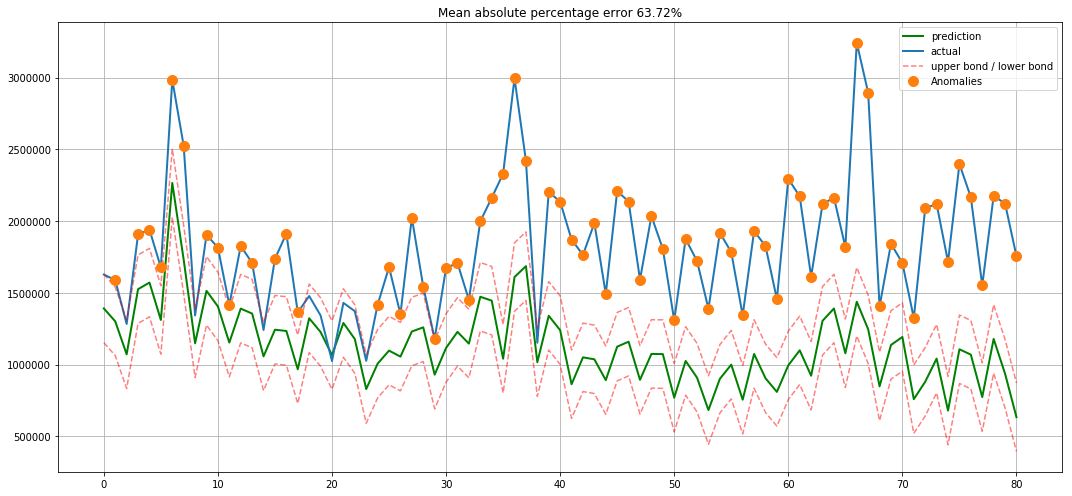

In [30]:
# Забустить этот временной ряд и убедиться, что по умолчанию xgb будет давать отвратительный результат
# catboost вместо xgb по причине проблем с установкой xgb на OS Win10

cat = CatBoostRegressor()

cat.fit(X_train_scaled, y_train)

plotModelResults(cat, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(cat)

In [ ]:
# бустинг с настройками по умолчанию дает результат гораздо хуже, чем линейная регрессия

In [31]:
# Крутое бонус-задание
# Разбейте подготовленные данные на train и test

X_train, X_test, y_train, y_test =\
prepareData(currency.GEMS_GEMS_SPENT, lag_start=7, lag_end=31, test_size=0.3, target_encoding=False)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [32]:
# Очистите временной ряд от линейного тренда при помощи построения однофакторной линейной регрессии,
# где таргетом будут значения ряда, а фактором - числовой ряд от 0 до len(train).
# Предсказанные по такой модели значения будут линейным трендом,
# который нужно вычесть из исходного ряда (подбробнее можно посмотреть здесь)

model = LinearRegression()

train_factors = []
for i in range(0, len(X_train_scaled)):
    train_factors.append(i)
    
model.fit(pd.DataFrame(train_factors), y_train)

y_train_trend = model.predict(pd.DataFrame(train_factors))

y_train_wo_trend = y_train - y_train_trend

In [33]:
# Теперь спрогнозируйте значения тренда по этой модели для тестового датасета,
# для этого нужно в качестве фактора взять числовой ряд от len(train) до len(test),
# очистите тестовый датасет от тренда при помощи этого прогноза

test_factors = []
for i in range(len(X_train_scaled), len(X_train_scaled)+len(X_test_scaled)):
    test_factors.append(i)

y_test_trend = model.predict(pd.DataFrame(test_factors))

y_test_wo_trend = y_test - y_test_trend

In [34]:
# Далее на очищенных от тренда данных train постройте xgboost и постройте прогноз на test

boost = CatBoostRegressor()

boost.fit(X_train_scaled, y_train_wo_trend)

y_hat_wo_trend = boost.predict(X_test_scaled)

0:	learn: 350930.3437161	total: 32.7ms	remaining: 32.6s
1:	learn: 347089.1549091	total: 66.8ms	remaining: 33.3s
2:	learn: 344203.4737170	total: 98.7ms	remaining: 32.8s
3:	learn: 341366.4234295	total: 122ms	remaining: 30.4s
4:	learn: 337290.2170518	total: 146ms	remaining: 29s
5:	learn: 333641.7252969	total: 172ms	remaining: 28.5s
6:	learn: 330780.3532258	total: 202ms	remaining: 28.7s
7:	learn: 327020.9715424	total: 229ms	remaining: 28.4s
8:	learn: 323788.4908287	total: 252ms	remaining: 27.7s
9:	learn: 320769.2712681	total: 275ms	remaining: 27.3s
10:	learn: 318325.6660697	total: 301ms	remaining: 27s
11:	learn: 315284.6526785	total: 333ms	remaining: 27.4s
12:	learn: 312472.6918770	total: 362ms	remaining: 27.5s
13:	learn: 309889.5016022	total: 384ms	remaining: 27s
14:	learn: 307034.0590349	total: 409ms	remaining: 26.9s
15:	learn: 304242.2663767	total: 432ms	remaining: 26.6s
16:	learn: 301636.7703271	total: 458ms	remaining: 26.5s
17:	learn: 299452.8399984	total: 483ms	remaining: 26.3s
18:	l

147:	learn: 145071.5023942	total: 3.69s	remaining: 21.2s
148:	learn: 144802.4958329	total: 3.71s	remaining: 21.2s
149:	learn: 144058.9348764	total: 3.73s	remaining: 21.2s
150:	learn: 143460.5574715	total: 3.75s	remaining: 21.1s
151:	learn: 142784.1614070	total: 3.78s	remaining: 21.1s
152:	learn: 142077.2799791	total: 3.8s	remaining: 21s
153:	learn: 141601.3879000	total: 3.82s	remaining: 21s
154:	learn: 141372.3744879	total: 3.84s	remaining: 20.9s
155:	learn: 140768.1378180	total: 3.87s	remaining: 20.9s
156:	learn: 140080.9771027	total: 3.88s	remaining: 20.9s
157:	learn: 139570.4414058	total: 3.9s	remaining: 20.8s
158:	learn: 139047.7745005	total: 3.92s	remaining: 20.8s
159:	learn: 138532.6571209	total: 3.95s	remaining: 20.7s
160:	learn: 137996.0272656	total: 3.96s	remaining: 20.7s
161:	learn: 137520.0576493	total: 3.98s	remaining: 20.6s
162:	learn: 137069.2136100	total: 4s	remaining: 20.6s
163:	learn: 136604.6634614	total: 4.03s	remaining: 20.5s
164:	learn: 136083.4795055	total: 4.05s	

293:	learn: 91596.5652965	total: 6.85s	remaining: 16.4s
294:	learn: 91524.7451207	total: 6.87s	remaining: 16.4s
295:	learn: 91416.7057851	total: 6.89s	remaining: 16.4s
296:	learn: 91125.7378583	total: 6.92s	remaining: 16.4s
297:	learn: 90946.4413553	total: 6.94s	remaining: 16.3s
298:	learn: 90894.8596180	total: 6.96s	remaining: 16.3s
299:	learn: 90534.1178358	total: 6.99s	remaining: 16.3s
300:	learn: 90415.0004158	total: 7.01s	remaining: 16.3s
301:	learn: 90184.8951870	total: 7.03s	remaining: 16.2s
302:	learn: 89961.3737749	total: 7.05s	remaining: 16.2s
303:	learn: 89627.4916272	total: 7.07s	remaining: 16.2s
304:	learn: 89496.4029456	total: 7.09s	remaining: 16.2s
305:	learn: 89086.2287483	total: 7.12s	remaining: 16.1s
306:	learn: 88565.8004252	total: 7.14s	remaining: 16.1s
307:	learn: 88458.4207836	total: 7.16s	remaining: 16.1s
308:	learn: 88259.7550837	total: 7.18s	remaining: 16.1s
309:	learn: 88021.0923700	total: 7.2s	remaining: 16s
310:	learn: 87791.0812803	total: 7.22s	remaining: 1

441:	learn: 68433.2263464	total: 10.2s	remaining: 12.8s
442:	learn: 68188.2386212	total: 10.2s	remaining: 12.8s
443:	learn: 68065.0474652	total: 10.2s	remaining: 12.8s
444:	learn: 67925.0424819	total: 10.2s	remaining: 12.8s
445:	learn: 67828.0880065	total: 10.3s	remaining: 12.7s
446:	learn: 67756.2913259	total: 10.3s	remaining: 12.7s
447:	learn: 67663.3793388	total: 10.3s	remaining: 12.7s
448:	learn: 67654.8864670	total: 10.3s	remaining: 12.7s
449:	learn: 67269.7189458	total: 10.3s	remaining: 12.6s
450:	learn: 67154.7545666	total: 10.4s	remaining: 12.6s
451:	learn: 67129.4916494	total: 10.4s	remaining: 12.6s
452:	learn: 67037.2693932	total: 10.4s	remaining: 12.5s
453:	learn: 66945.7433289	total: 10.4s	remaining: 12.5s
454:	learn: 66817.9330664	total: 10.4s	remaining: 12.5s
455:	learn: 66783.0787701	total: 10.4s	remaining: 12.5s
456:	learn: 66748.3860361	total: 10.5s	remaining: 12.4s
457:	learn: 66549.4437894	total: 10.5s	remaining: 12.4s
458:	learn: 66516.3171882	total: 10.5s	remaining

589:	learn: 55371.1291261	total: 13s	remaining: 9.04s
590:	learn: 55134.3977952	total: 13s	remaining: 9.02s
591:	learn: 55020.7905230	total: 13s	remaining: 8.99s
592:	learn: 54927.5829888	total: 13.1s	remaining: 8.97s
593:	learn: 54904.5322166	total: 13.1s	remaining: 8.95s
594:	learn: 54821.0171506	total: 13.1s	remaining: 8.92s
595:	learn: 54704.6390918	total: 13.1s	remaining: 8.9s
596:	learn: 54630.4039496	total: 13.1s	remaining: 8.87s
597:	learn: 54470.4810015	total: 13.2s	remaining: 8.85s
598:	learn: 54442.4142123	total: 13.2s	remaining: 8.83s
599:	learn: 54384.5274746	total: 13.2s	remaining: 8.8s
600:	learn: 54172.1673517	total: 13.2s	remaining: 8.78s
601:	learn: 54042.0670692	total: 13.2s	remaining: 8.76s
602:	learn: 54038.3612529	total: 13.3s	remaining: 8.74s
603:	learn: 54031.2115799	total: 13.3s	remaining: 8.72s
604:	learn: 54020.5956852	total: 13.3s	remaining: 8.69s
605:	learn: 54013.2795345	total: 13.3s	remaining: 8.67s
606:	learn: 54006.6411081	total: 13.4s	remaining: 8.64s


737:	learn: 47045.2483223	total: 16s	remaining: 5.66s
738:	learn: 46983.7214204	total: 16s	remaining: 5.64s
739:	learn: 46979.2246698	total: 16s	remaining: 5.62s
740:	learn: 46915.7386560	total: 16s	remaining: 5.6s
741:	learn: 46910.3367037	total: 16s	remaining: 5.58s
742:	learn: 46905.0215952	total: 16.1s	remaining: 5.55s
743:	learn: 46765.8493686	total: 16.1s	remaining: 5.53s
744:	learn: 46688.6023370	total: 16.1s	remaining: 5.51s
745:	learn: 46581.5294240	total: 16.1s	remaining: 5.49s
746:	learn: 46524.8642873	total: 16.1s	remaining: 5.47s
747:	learn: 46505.1708146	total: 16.2s	remaining: 5.45s
748:	learn: 46503.4676911	total: 16.2s	remaining: 5.43s
749:	learn: 46471.9601234	total: 16.2s	remaining: 5.4s
750:	learn: 46320.7709412	total: 16.2s	remaining: 5.38s
751:	learn: 46260.2226799	total: 16.3s	remaining: 5.36s
752:	learn: 46223.3636541	total: 16.3s	remaining: 5.34s
753:	learn: 46219.7938747	total: 16.3s	remaining: 5.32s
754:	learn: 46215.2993794	total: 16.3s	remaining: 5.3s
755:	

885:	learn: 39697.4502309	total: 18.9s	remaining: 2.43s
886:	learn: 39668.3520900	total: 18.9s	remaining: 2.41s
887:	learn: 39604.4947424	total: 18.9s	remaining: 2.39s
888:	learn: 39501.6730199	total: 19s	remaining: 2.37s
889:	learn: 39425.3947461	total: 19s	remaining: 2.35s
890:	learn: 39402.9875978	total: 19s	remaining: 2.33s
891:	learn: 39397.2145818	total: 19s	remaining: 2.3s
892:	learn: 39354.0321881	total: 19s	remaining: 2.28s
893:	learn: 39324.4353694	total: 19.1s	remaining: 2.26s
894:	learn: 39243.0416924	total: 19.1s	remaining: 2.24s
895:	learn: 39205.0555963	total: 19.1s	remaining: 2.22s
896:	learn: 39142.8322016	total: 19.1s	remaining: 2.19s
897:	learn: 39129.8902701	total: 19.1s	remaining: 2.17s
898:	learn: 39123.0390130	total: 19.2s	remaining: 2.15s
899:	learn: 38970.2873608	total: 19.2s	remaining: 2.13s
900:	learn: 38840.8951724	total: 19.2s	remaining: 2.11s
901:	learn: 38710.4450963	total: 19.2s	remaining: 2.09s
902:	learn: 38704.3135437	total: 19.3s	remaining: 2.07s
903

In [35]:
# Наконец, просуммируйте предсказанное значение тренда и прогнозы бустинга,
# чтобы получить красивый итоговый прогноз временного ряда

y_hat = y_test_trend + y_hat_wo_trend

mean_absolute_percentage_error(y_test, y_hat)

21.334358385695133

In [57]:
y_hat = pd.Series(y_hat)
y_hat.index = y_test.index

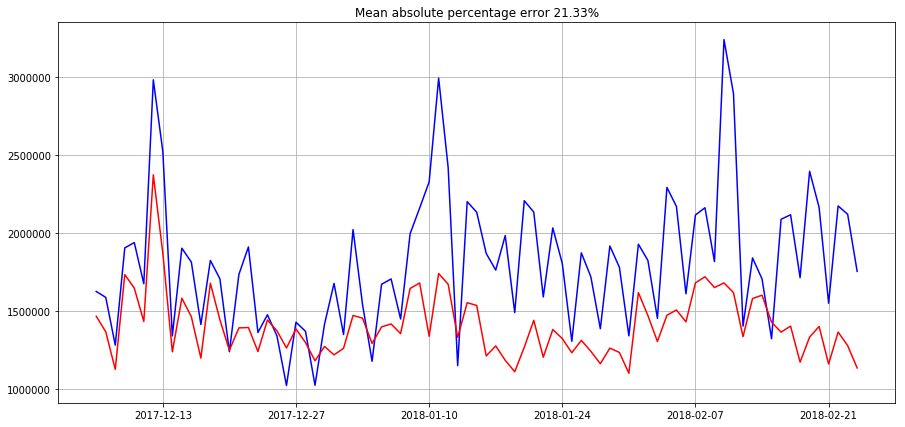

In [64]:
plt.figure(figsize=(15, 7))
plt.plot(y_test, 'b')
plt.plot(y_hat, 'r')
plt.title("Mean absolute percentage error {0:.2f}%".format(mean_absolute_percentage_error(y_test, y_hat)))
plt.grid(True)
plt.show()

In [ ]:
# Средння абсолютная процентная ошибка ( MAPE ) составила всего 21.33% ( результат может варьироваться )
# Бустинг на данных, очищенных от линейного тренда, дает лучший результат ( по метрике MAPE ) среди рассмотренных моделей